In [47]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 200)

# 1. Install Libraries

# 2. Load Libraries

In [23]:
library(tidyverse)
library(tidymodels)
library(readxl)
library(janitor)
library(plotly)
library(corrr)
library(sjPlot)
library(lmerTest)  # Use lmerTest to get p-values
library(broom.mixed)
#library(forcats)
library(stringr)
library(broom)
library(GGally)
library(ggpubr)
library(patchwork)
library(agricolae)
library(gander)
library(skimr)


Attaching package: ‘skimr’


The following object is masked from ‘package:corrr’:

    focus




# 3. Load data

In [26]:
data <- readxl::read_excel("data/All Year 28 R Barley trial data.xlsx", sheet = "Overall_2") %>% 
  clean_names() %>% 
  filter(!(location == "Falher" & year == 2024)) %>% 
  mutate(yield_adj_to_13_5_percent = as.numeric(yield_adj_to_13_5_percent),
         yield_adj_to_13_5_percent_bu = as.numeric(yield_adj_to_13_5_percent_bu),
         avg_height_at_phys_maturity = as.numeric(avg_height_at_phys_maturity),
         lodging_index_1 = as.numeric(lodging_index_1),
         lodging_index_2 = as.numeric(lodging_index_2),
         lodging_index_3 = as.numeric(lodging_index_3),
         tkw_avg_adjusted_to_13_5_percent_moisture = as.numeric(tkw_avg),
         ndf_percent_dm = as.numeric(ndf_percent_dm),
         iv_d_ec_percent_dm = as.numeric(iv_d_ec_percent_dm),
         starch_percent_dm = as.numeric(starch_percent_dm),
         test_weight_kg_h_l = as.numeric(test_weight_kg_h_l),
         protein_percent_dm = as.numeric(protein_percent_dm),
         dtm = as.numeric(dtm),
         grain_moisture_percent = as.numeric(grain_moisture_percent)) %>% 
  mutate(cultivar = case_when(cultivar == "TR18647"~ "AB_Hague",
                              .default = cultivar)) 
head(data) 

Warning message:
“There were 13 warnings in `mutate()`.
The first warning was:
ℹ In argument: `yield_adj_to_13_5_percent =
  as.numeric(yield_adj_to_13_5_percent)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 12 remaining warnings.”


year location  plot block overall_trt_number cultivar      pgr_trt_number
1 2022 Vermilion 101  1     1                  CDC_Austenson 1             
2 2022 Vermilion 102  1     2                  CDC_Austenson 2             
3 2022 Vermilion 103  1     3                  CDC_Austenson 3             
4 2022 Vermilion 104  1     4                  CDC_Austenson 4             
5 2022 Vermilion 105  1     5                  CDC_Austenson 5             
6 2022 Vermilion 106  1     6                  CDC_Austenson 6             
  pgr_trt_name emerge_avg_plants_m2 week_1_height ⋯ test_weight_kg_h_l
1 No_PGR       139.13043478260869   .             ⋯ 66.13             
2 M62.5_21-24  136.95652173913044   .             ⋯ 65.01             
3 M62.5_30-32  158.69565217391303   .             ⋯ 69.78             
4 M62.5_37     158.69565217391303   .             ⋯ 65.25             
5 M125_30-32   210.86956521739128   .             ⋯ 66.56             
6 M125_37      182.60869565217391   .             ⋯ 67.16             
  tkw_1_100_kernels  tkw_2_100_kernels  tkw_avg
1 4.5                4.7                46.0   
2 4.5999999999999996 4.3                44.5   
3 4.8                4.9000000000000004 48.5   
4 4.5999999999999996 4.8                47.0   
5 4.8                4.8                48.0   
6 4.5999999999999996 4.5999999999999996 46.0   
  tkw_avg_adjusted_to_13_5_percent_moisture protein_percent_dm
1 46.0                                      12.35137          
2 44.5                                      12.16454          
3 48.5                                      11.94270          
4 47.0                                      11.90405          
5 48.0                                      12.28261          
6 46.0                                      12.39285          
  starch_percent_dm ndf_percent_dm iv_d_ec_percent_dm
1 61.80709          16.94731       3484.369          
2 61.71610          16.99448       3492.453          
3 60.99495          17.04296       3429.073          
4 61.71217          16.27136       3398.832          
5 61.19565          17.06522       3464.130          
6 60.91529          16.46905       3407.598          
  gross_return_yield_x_selling_rate_5_85
1  793.0985                             
2  744.2021                             
3  685.2741                             
4 1029.5546                             
5  809.3649                             
6  913.5992

# 4. Data Exploration

## 4.1 Summary data

In [84]:
install.packages("flextable")

also installing the dependencies ‘fontBitstreamVera’, ‘fontLiberation’, ‘fontquiver’, ‘zip’, ‘gdtools’, ‘officer’





The downloaded binary packages are in
	/var/folders/9q/7cjjj_nj12l896f06bdg0mp40000gn/T//RtmpOzK87G/downloaded_packages


In [86]:
skimr::skim(data) %>% print()

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             864   
Number of columns          41    
_______________________          
Column type frequency:           
  character                20    
  numeric                  21    
________________________         
Group variables            None  

── Variable type: character ────────────────────────────────────────────────────
   skim_variable                    n_missing complete_rate min max empty
 1 location                                 0         1       6  10     0
 2 cultivar                                 0         1       4  13     0
 3 pgr_trt_name                             0         1       6  25     0
 4 emerge_avg_plants_m2                     0         1       1  18     0
 5 week_1_height                            0         1       1  18     0
 6 week_2_height                            0         1       1  18     0
 7 week_3_height   

## 4.2 Histograms

In [4]:
# Custom theme
theme_nice <- function(){
  theme_bw()+
  theme(axis.title = element_text(size = 20),
        axis.text = element_text(size = 20),
        plot.title = element_text(size = 20),
        strip.text = element_text(size = 18))
}

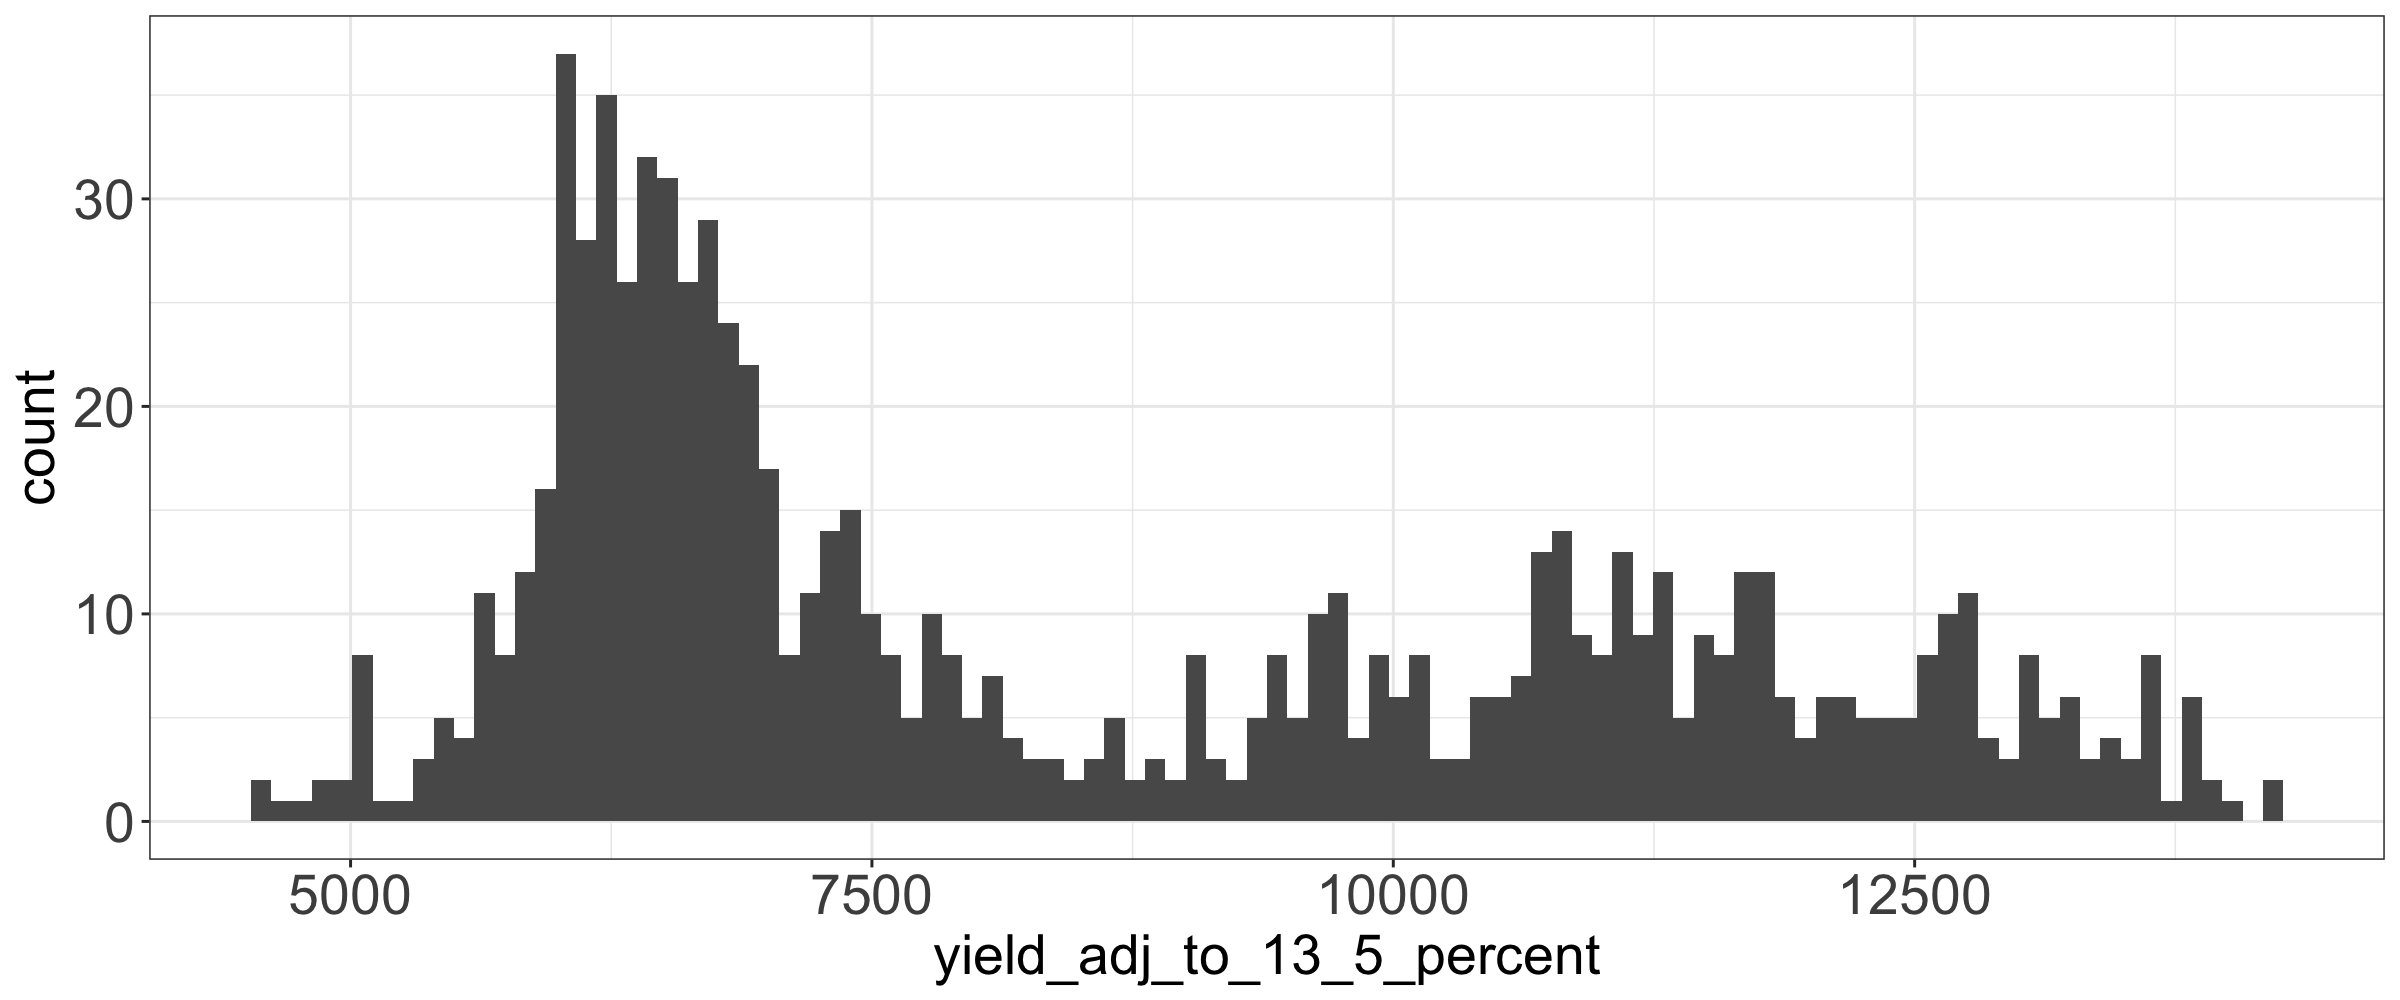

In [5]:
data %>% 
drop_na(yield_adj_to_13_5_percent)%>%
  ggplot(aes(yield_adj_to_13_5_percent))+
  geom_histogram(bins = 100)+
theme_nice()

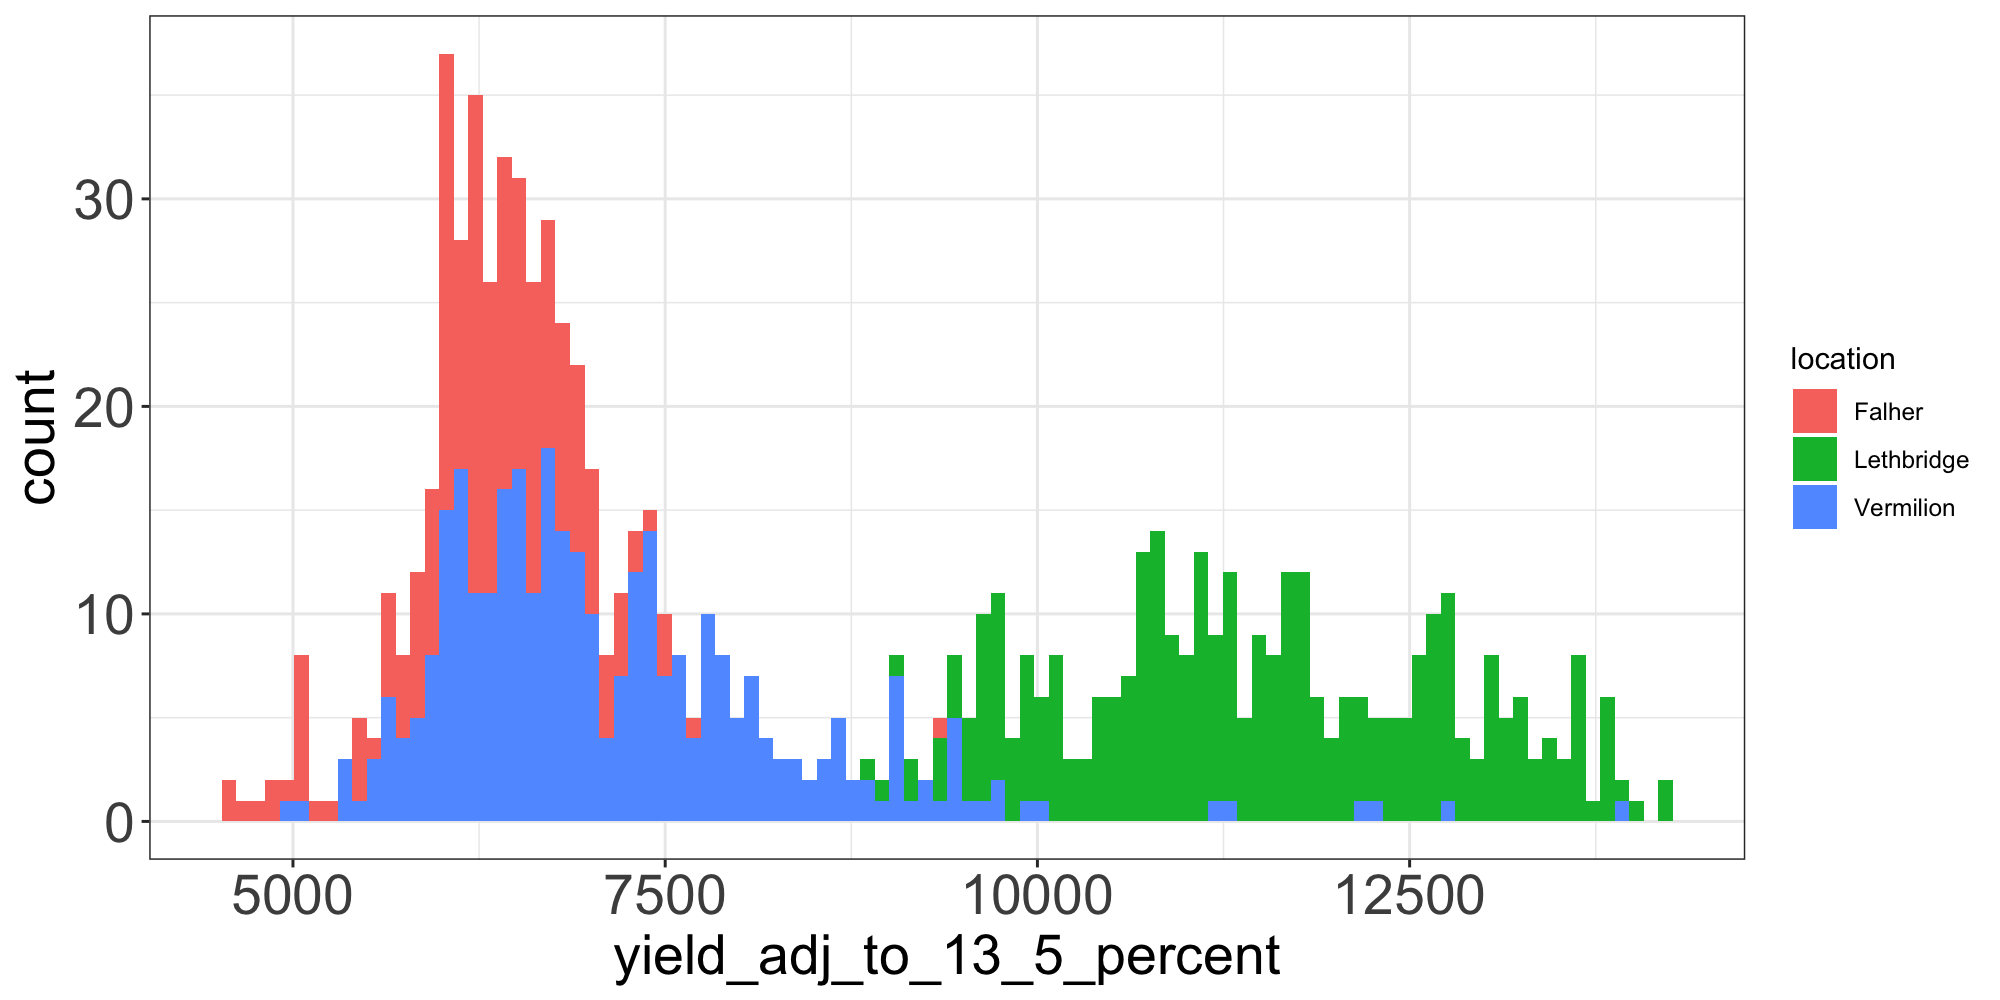

In [52]:
data %>% 
drop_na(yield_adj_to_13_5_percent)%>%
  ggplot(aes(yield_adj_to_13_5_percent, fill = location))+
  geom_histogram(bins = 100)+
theme_nice()

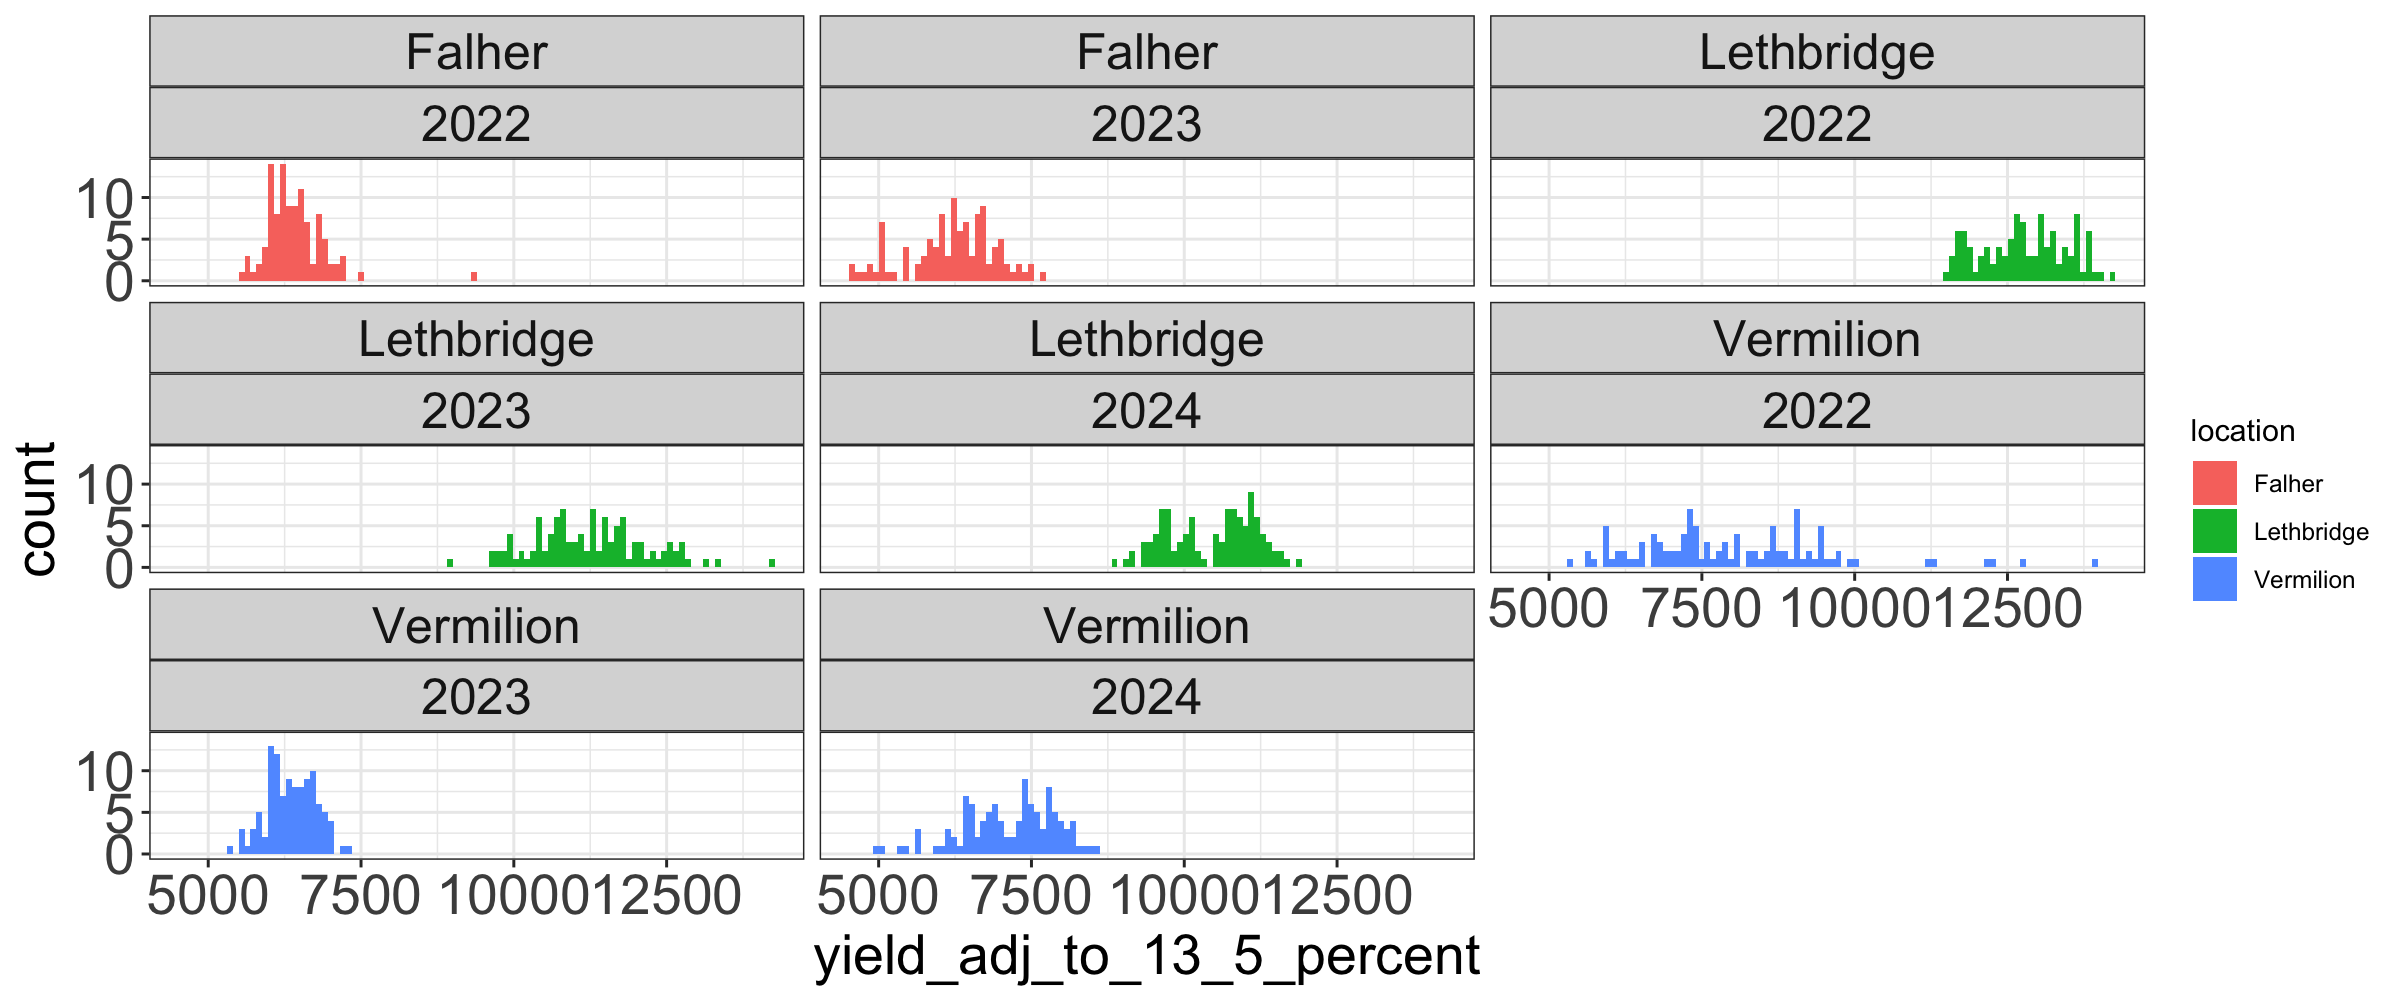

In [53]:
options(repr.plot.width = 12, repr.plot.height = 5, repr.plot.res = 200)
data %>% 
drop_na(yield_adj_to_13_5_percent)%>%
  ggplot(aes(yield_adj_to_13_5_percent, fill = location))+
  geom_histogram(bins = 100)+
  facet_wrap(location ~ year)+
theme_nice()

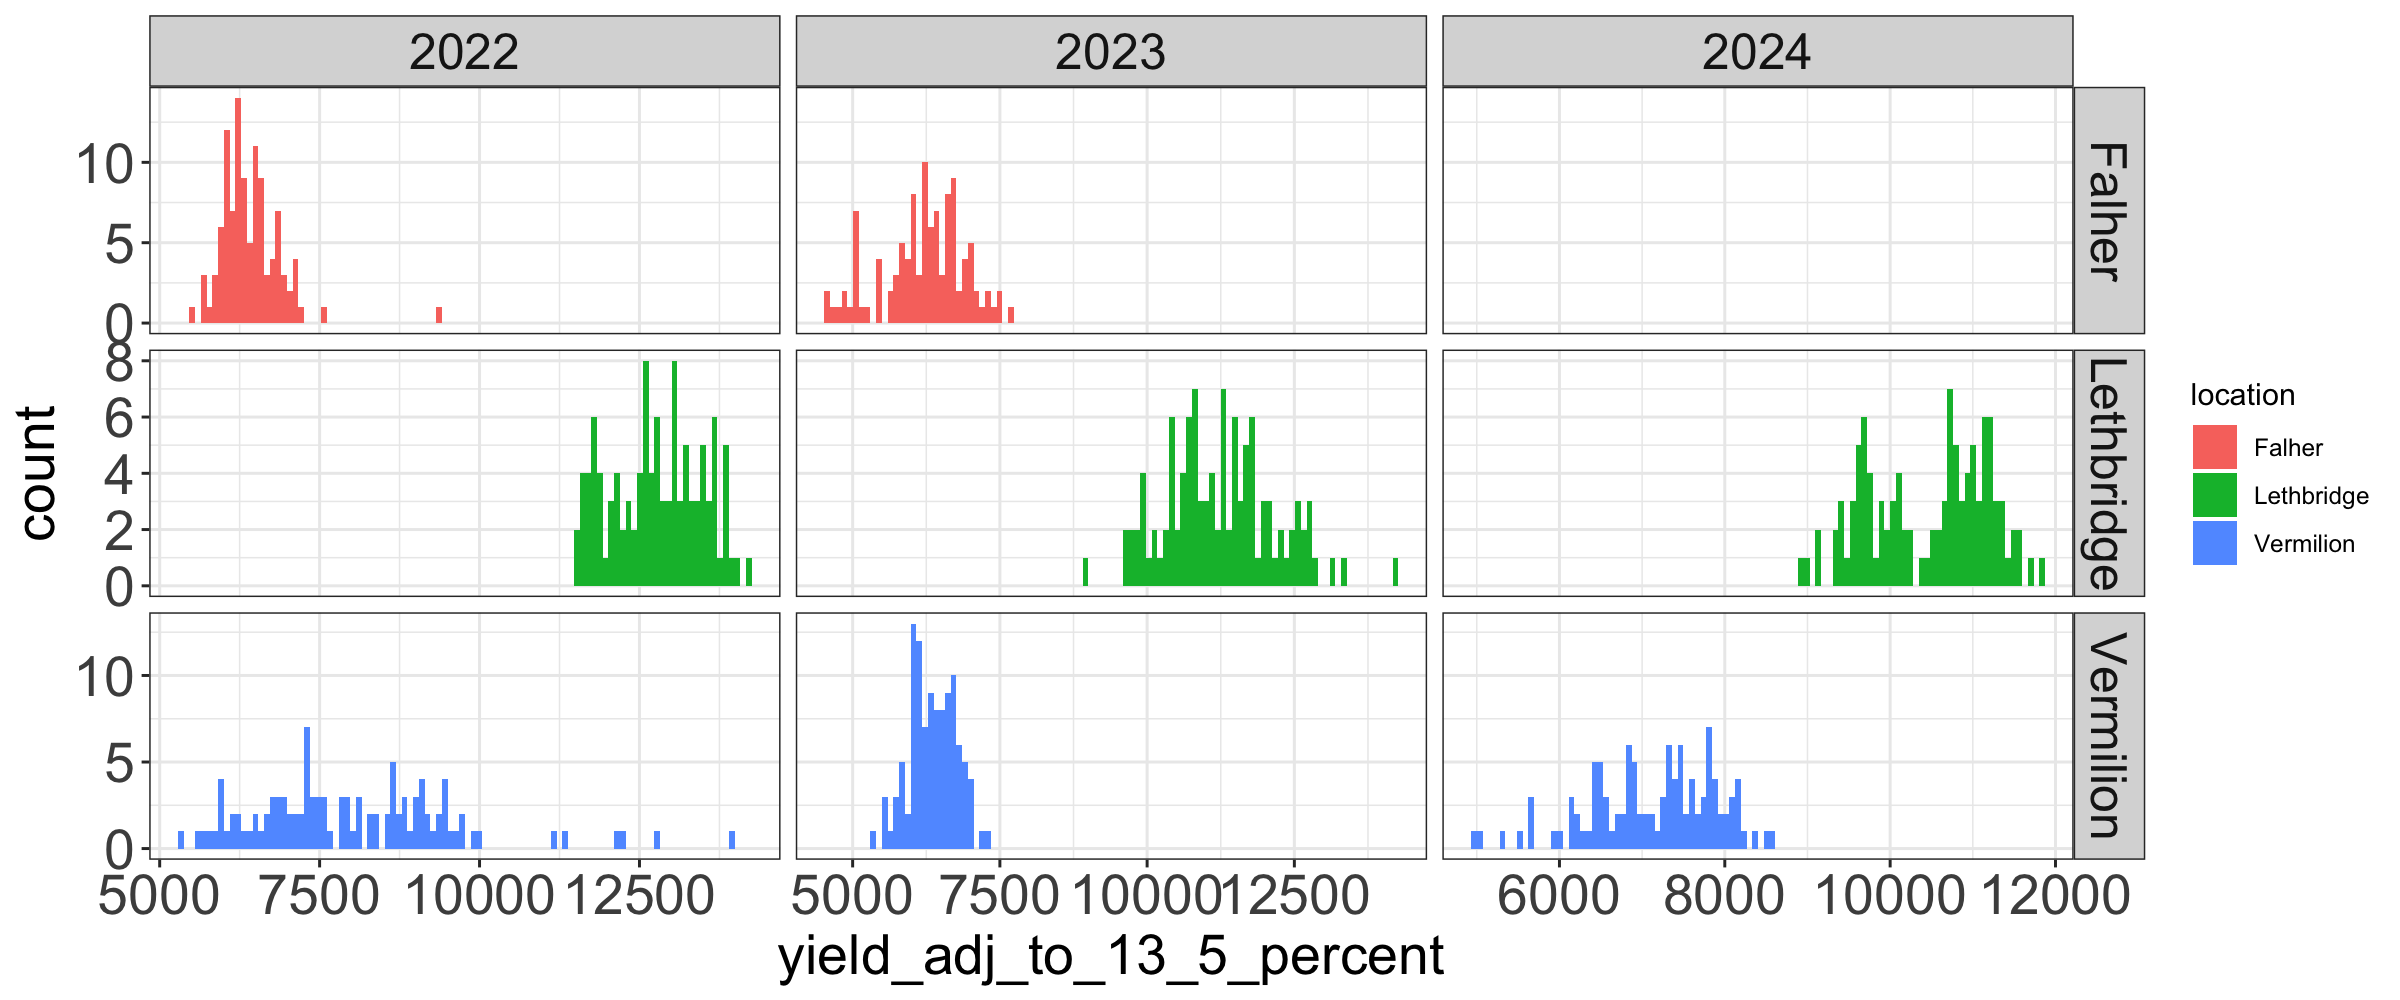

In [80]:
options(repr.plot.width = 12, repr.plot.height = 5, repr.plot.res = 200)
data %>% 
drop_na(yield_adj_to_13_5_percent)%>%
  ggplot(aes(yield_adj_to_13_5_percent, fill = location))+
  geom_histogram(bins = 100)+
  #geom_density(aes(alpha = 0.3))+
  facet_grid(location ~ year, scales = "free")+
theme_nice()

# 5. Data cleaning

In [60]:
cleaned_data_temp <-
  data %>% 
  mutate(lodging_avg = (lodging_index_1 + lodging_index_2 + lodging_index_3) /3) %>% 
  rename(tkw = tkw_avg_adjusted_to_13_5_percent_moisture,
         ndf_percent_af = ndf_percent_dm,
         plant_height_maturity_cm = emerge_avg_plants_m2,
         yield_bu_acre = yield_adj_to_13_5_percent_bu
         ) %>% 
  select("year", "location", "cultivar", "pgr_trt_name",  "yield_bu_acre",
  "lodging_index_3",
  "protein_percent_dm",
  "avg_height_at_phys_maturity",
  "tkw",
  "test_weight_kg_h_l",
  "dtm",
  "ndf_percent_af",
  "iv_d_ec_percent_dm",
  "grain_moisture_percent",
   "starch_percent_dm",
  "yield_adj_to_13_5_percent",
  "lodging_avg",
  "lodging_index_1",
  "lodging_index_2",
  "lodging_index_3")

# 6. Feature engineering

In [61]:
# Create a recipe
rec_1 <- recipe(yield_adj_to_13_5_percent ~ ., data = cleaned_data_temp) %>%
  step_impute_knn(all_predictors(), neighbors = 20)  # use k = 5

# Prep the recipe
rec_prepped_1 <- prep(rec_1)

# Apply the imputation to the full dataset
cleaned_data_imputed_1 <- bake(rec_prepped_1, new_data = NULL) %>% 
  select(-yield_adj_to_13_5_percent)

In [62]:
# Create a recipe
rec_2 <- recipe(yield_bu_acre ~ ., data = cleaned_data_temp) %>%
  step_impute_knn(all_predictors(), neighbors = 20)  # use k = 5

# Prep the recipe
rec_prepped_2 <- prep(rec_2)

# Apply the imputation to the full dataset
cleaned_data_imputed_2 <- bake(rec_prepped_2, new_data = NULL) %>% 
  select(-yield_bu_acre)

In [63]:
cleaned_data_imputed <- cleaned_data_imputed_1 %>% 
  left_join(cleaned_data_imputed_2) 
head(cleaned_data_imputed)

Joining with `by = join_by(year, location, cultivar, pgr_trt_name,
lodging_index_3, protein_percent_dm, avg_height_at_phys_maturity, tkw,
test_weight_kg_h_l, dtm, ndf_percent_af, iv_d_ec_percent_dm,
grain_moisture_percent, starch_percent_dm, lodging_avg, lodging_index_1,
lodging_index_2)`


year location  cultivar      pgr_trt_name yield_bu_acre lodging_index_3
1 2022 Vermilion CDC_Austenson No_PGR       135.5724      3.333333       
2 2022 Vermilion CDC_Austenson M62.5_21-24  127.2140      0.000000       
3 2022 Vermilion CDC_Austenson M62.5_30-32  117.1409      0.000000       
4 2022 Vermilion CDC_Austenson M62.5_37     175.9922      0.000000       
5 2022 Vermilion CDC_Austenson M125_30-32   138.3530      0.000000       
6 2022 Vermilion CDC_Austenson M125_37      156.1708      0.000000       
  protein_percent_dm avg_height_at_phys_maturity tkw  test_weight_kg_h_l
1 12.35137           72.33333                    46.0 66.13             
2 12.16454           74.00000                    44.5 65.01             
3 11.94270           69.66667                    48.5 69.78             
4 11.90405           71.66667                    47.0 65.25             
5 12.28261           71.00000                    48.0 66.56             
6 12.39285           76.66667                    46.0 67.16             
  dtm      ndf_percent_af iv_d_ec_percent_dm grain_moisture_percent
1 88.55556 16.94731       3484.369           11.91                 
2 91.91429 16.99448       3492.453           11.37                 
3 92.14286 17.04296       3429.073           11.61                 
4 91.68687 16.27136       3398.832           14.29                 
5 94.79487 17.06522       3464.130           12.47                 
6 93.10989 16.46905       3407.598           12.28                 
  starch_percent_dm lodging_avg lodging_index_1 lodging_index_2
1 61.80709          2.222222    0               3.333333       
2 61.71610          0.000000    0               0.000000       
3 60.99495          0.000000    0               0.000000       
4 61.71217          0.000000    0               0.000000       
5 61.19565          0.000000    0               0.000000       
6 60.91529          0.000000    0               0.000000       
  yield_adj_to_13_5_percent
1 7292.860                 
2 6843.238                 
3 6301.371                 
4 9467.169                 
5 7442.436                 
6 8400.912

## Boxplots

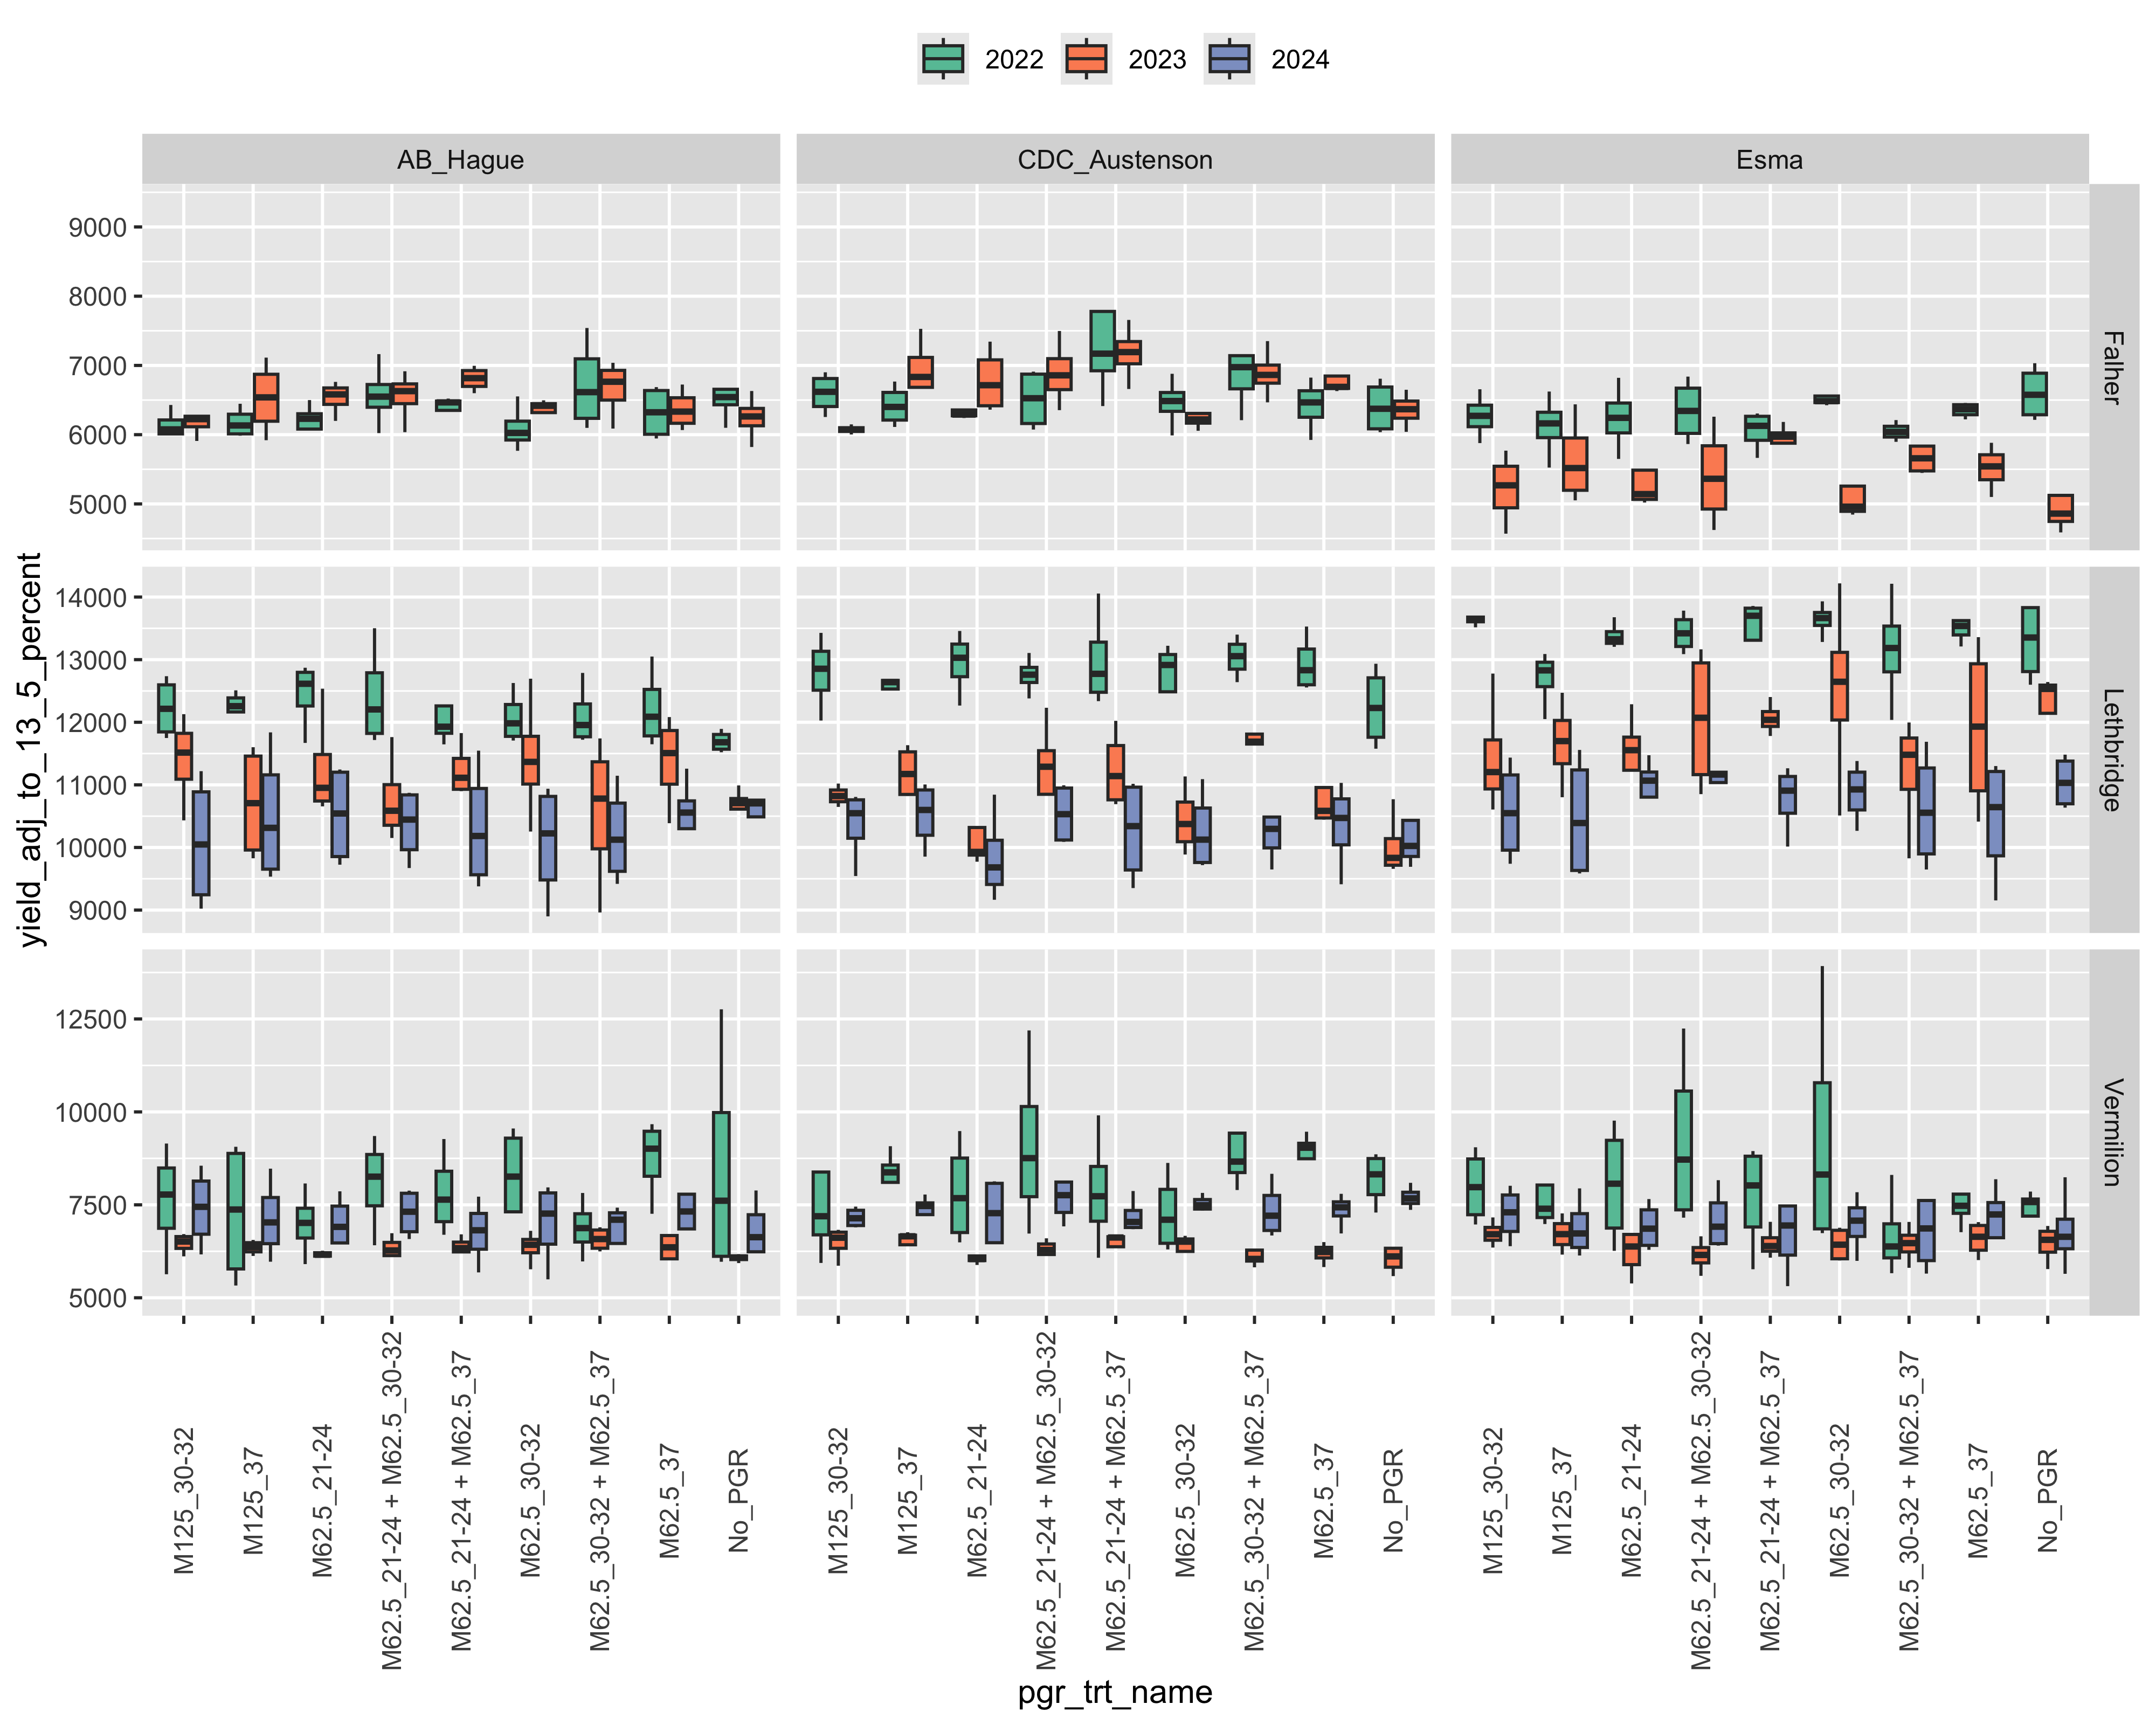

In [76]:
options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 400)
cleaned_data_imputed %>% 
drop_na(yield_adj_to_13_5_percent)%>%
  ggplot(aes(pgr_trt_name, yield_adj_to_13_5_percent, fill = as.factor(year)))+
  geom_boxplot(outlier.shape = NA)+
facet_grid(location ~ cultivar, scales = "free_y")+
 scale_fill_brewer(palette = "Set2") +
theme(axis.text.x = element_text(angle = 90, vjust = 0.5),
     legend.position = "top")+
labs(fill = "")

In [77]:
names(cleaned_data_imputed)

[1] "year"                        "location"                   
 [3] "cultivar"                    "pgr_trt_name"               
 [5] "yield_bu_acre"               "lodging_index_3"            
 [7] "protein_percent_dm"          "avg_height_at_phys_maturity"
 [9] "tkw"                         "test_weight_kg_h_l"         
[11] "dtm"                         "ndf_percent_af"             
[13] "iv_d_ec_percent_dm"          "grain_moisture_percent"     
[15] "starch_percent_dm"           "lodging_avg"                
[17] "lodging_index_1"             "lodging_index_2"            
[19] "yield_adj_to_13_5_percent"

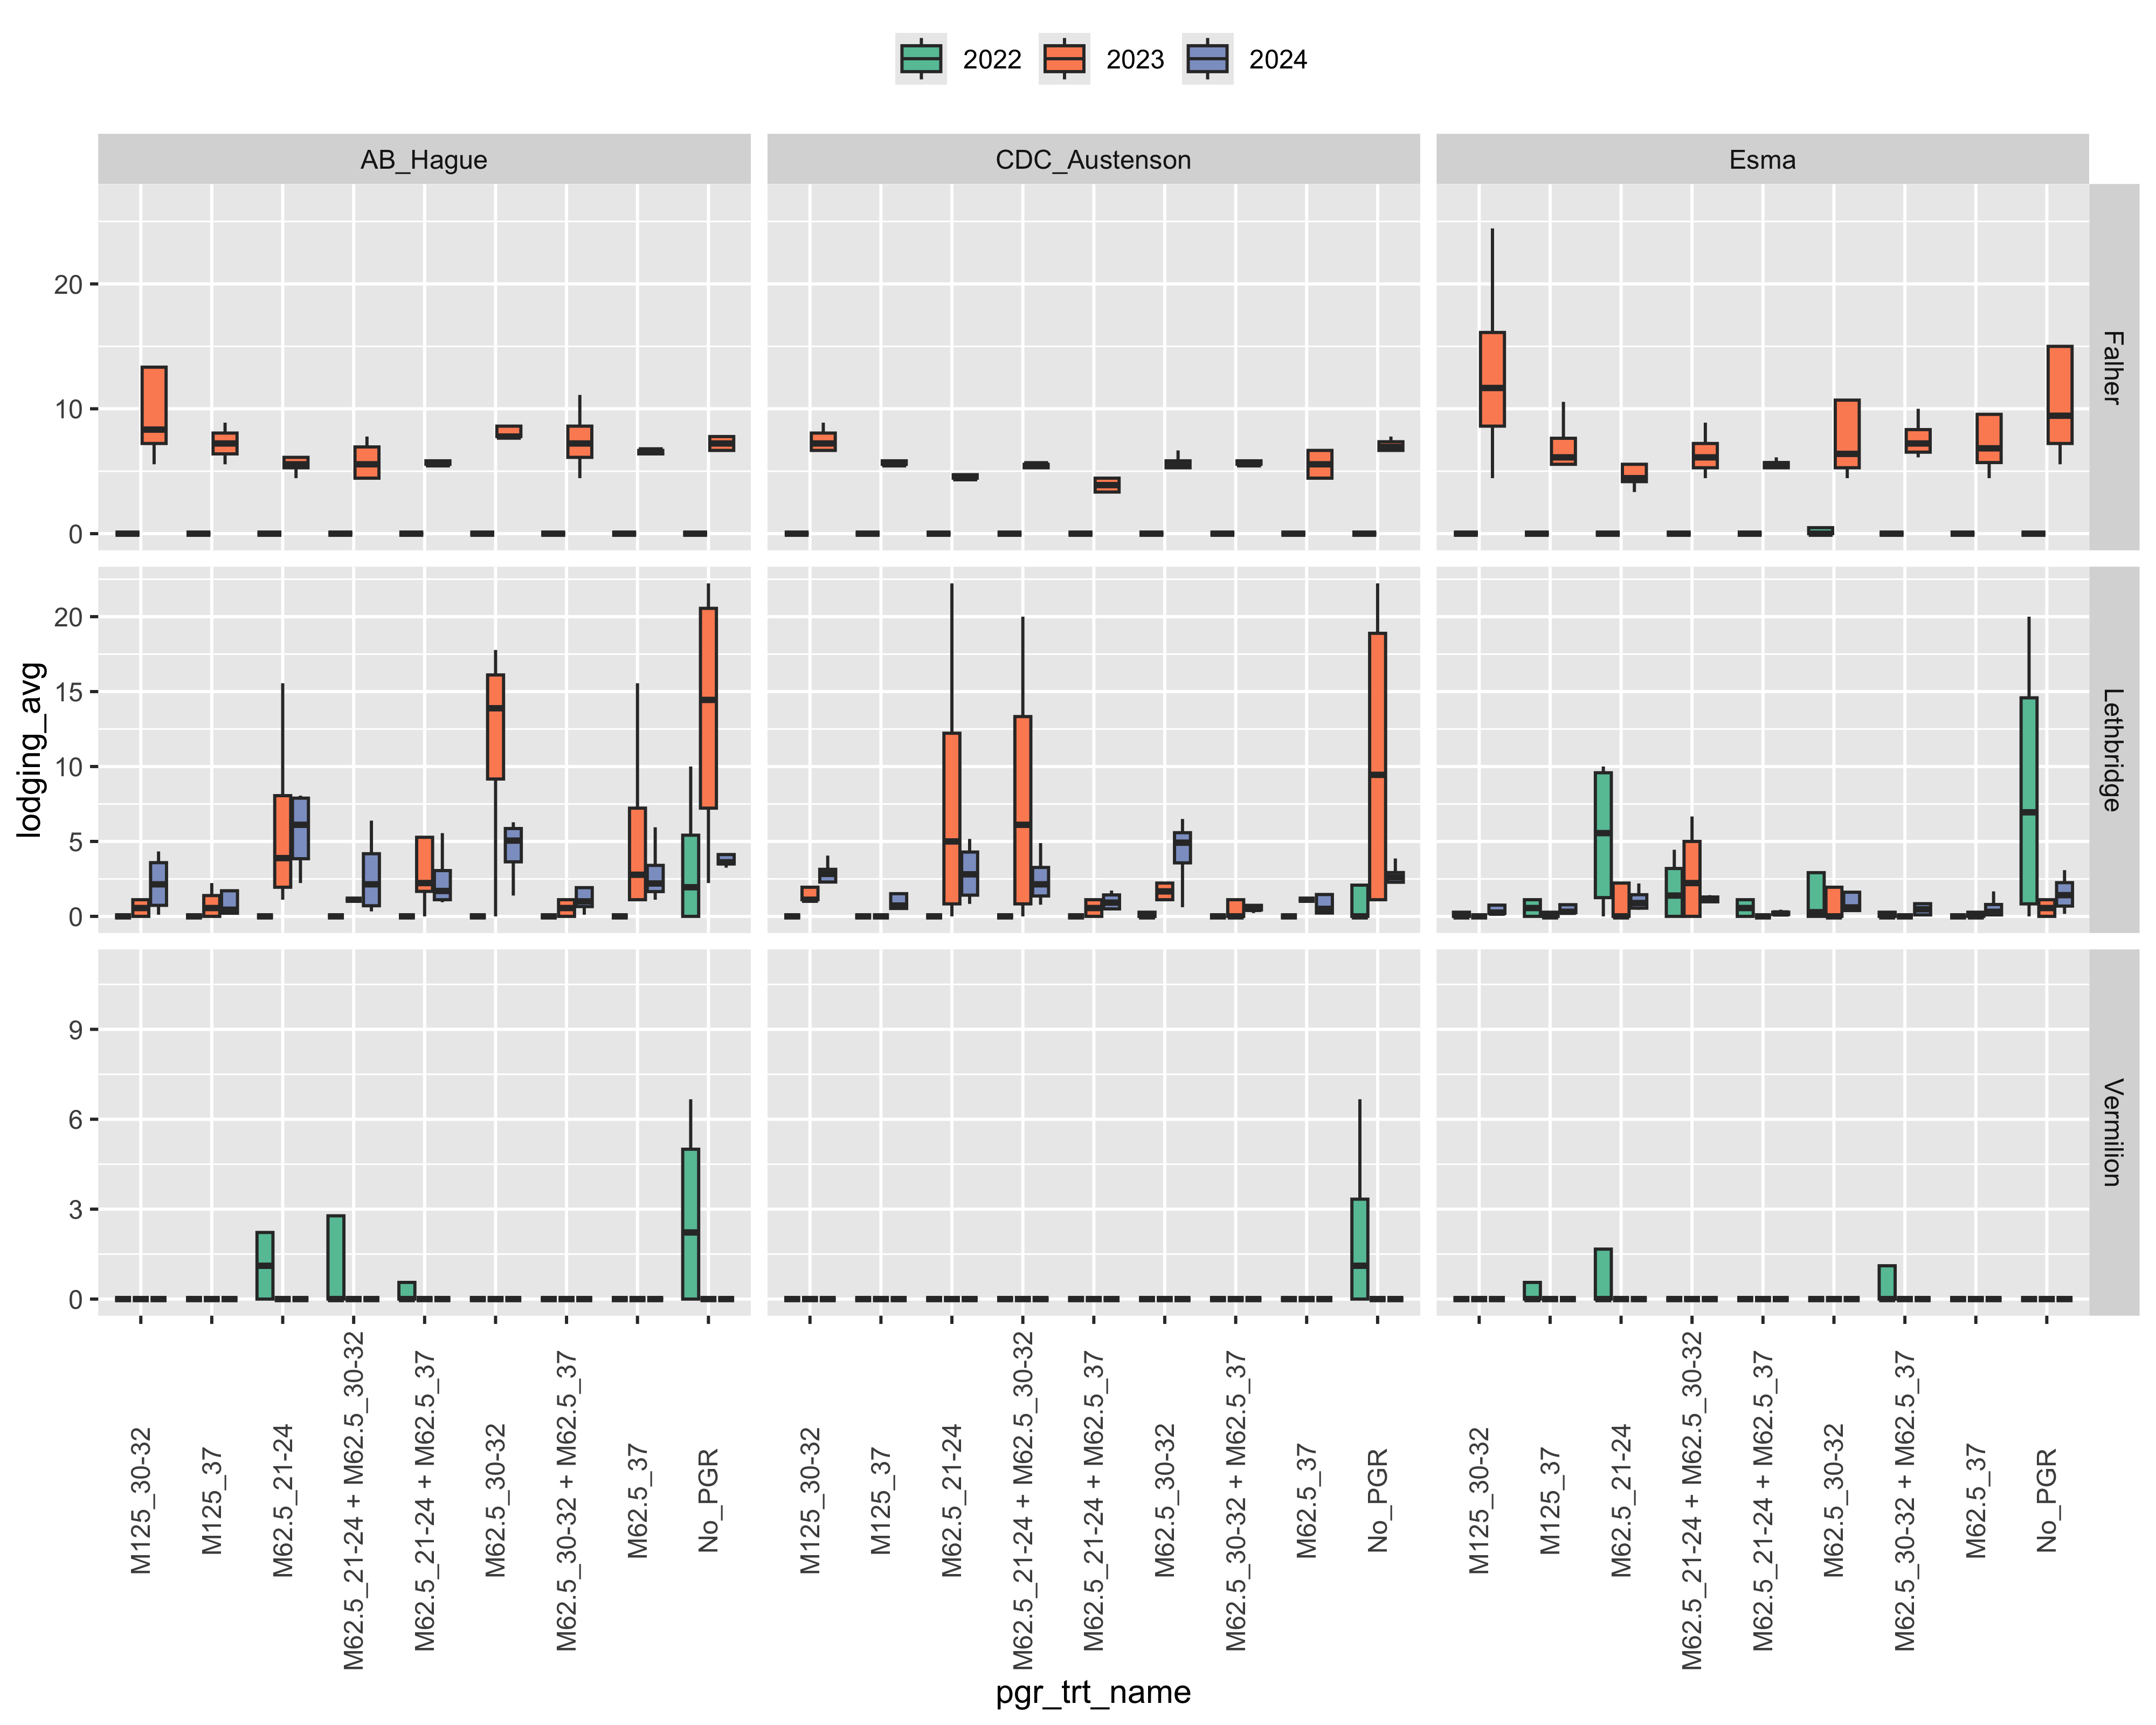

In [78]:
options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 400)
cleaned_data_imputed %>% 
  ggplot(aes(pgr_trt_name, lodging_avg, fill = as.factor(year)))+
  geom_boxplot(outlier.shape = NA)+
facet_grid(location ~ cultivar, scales = "free_y")+
 scale_fill_brewer(palette = "Set2") +
theme(axis.text.x = element_text(angle = 90, vjust = 0.5),
     legend.position = "top")+
labs(fill = "")

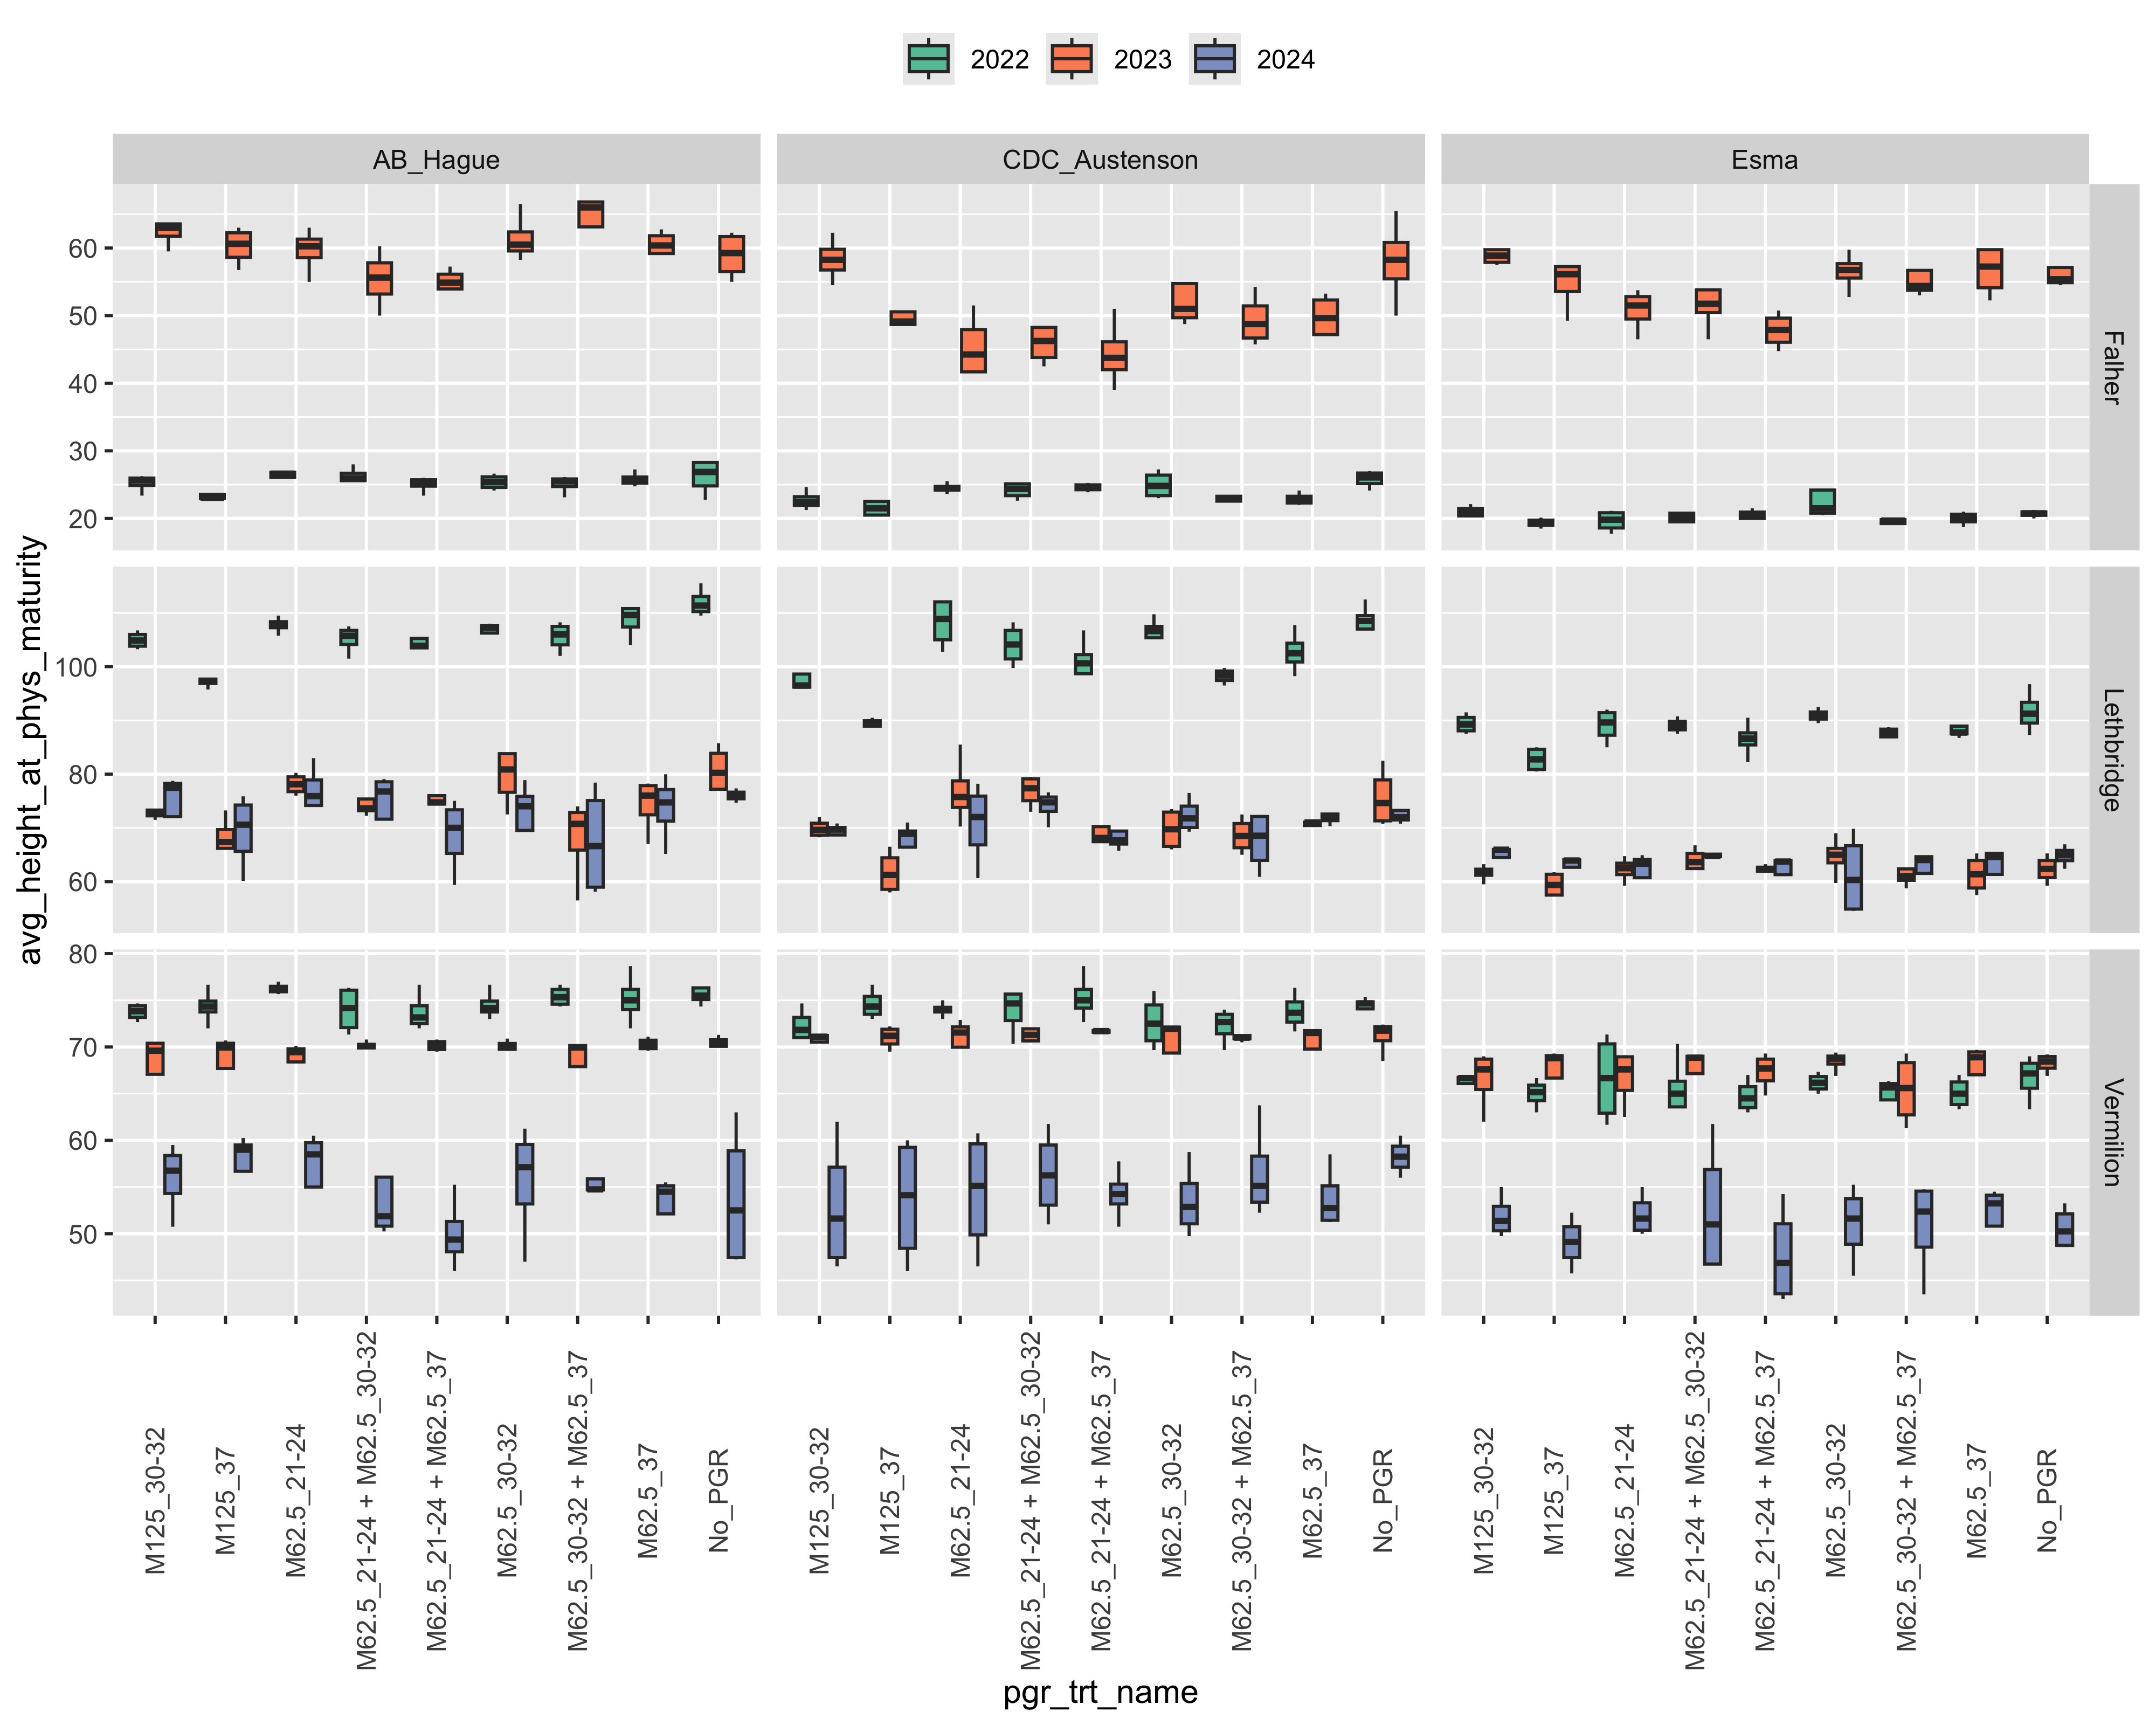

In [79]:
options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 400)
cleaned_data_imputed %>% 
  ggplot(aes(pgr_trt_name, avg_height_at_phys_maturity, fill = as.factor(year)))+
  geom_boxplot(outlier.shape = NA)+
facet_grid(location ~ cultivar, scales = "free_y")+
 scale_fill_brewer(palette = "Set2") +
theme(axis.text.x = element_text(angle = 90, vjust = 0.5),
     legend.position = "top")+
labs(fill = "")

# 5. Mixed Modeling

## 5.2 New data for model interaction

In [60]:
pgr_trt_name = c("No_PGR", "M62.5_21-24", "M62.5_30-32", "M125_30-32", "M62.5_37",
                 "M125_37", "M62.5_21-24 + M62.5_37", "M62.5_21-24 + M62.5_30-32",
                 "M62.5_30-32 + M62.5_37")
cultivation_cost_dollar = c(402.2, 411.7, 421.2, 430.7, 411.7,
                            421.2, 421.2, 430.7, 430.7)
econonmic_data <- data.frame(pgr_trt_name, cultivation_cost_dollar)

In [61]:
data_int <- cleaned_data_imputed %>% 
  left_join(econonmic_data) %>% 
  mutate(gross_return = yield_bu_acre * 5.85,
         net_return = gross_return - cultivation_cost_dollar) %>% 
  mutate(PGR_dose = case_when(
    pgr_trt_name == "No_PGR" ~ 0,
    pgr_trt_name %in% c("M62.5_21-24", "M62.5_30-32", "M62.5_37") ~ 62.5,
    .default = 125
  ),
  PGR_growth_stage = case_when(
     pgr_trt_name == "No_PGR" ~ "Control",
     pgr_trt_name == "M62.5_21-24" ~ "GS 21-24 (ET)",
     pgr_trt_name %in% c("M62.5_30-32", "M125_30-32") ~ "GS 30-32 (SE)",
     pgr_trt_name %in% c("M62.5_37", "M125_37") ~ "GS 37 (FLE)",
     pgr_trt_name == "M62.5_21-24 + M62.5_37" ~ "GS 21-24 (ET) + GS 37 (FLE)",
     pgr_trt_name == "M62.5_21-24 + M62.5_30-32" ~ "GS 21-24 (ET) + GS 30-32 (SE)",
     pgr_trt_name == "M62.5_30-32 + M62.5_37" ~ "GS 30-32 (SE) + GS 37 (FLE)"
  )
  )
head(data_int)

Joining with `by = join_by(pgr_trt_name)`


year location  cultivar      pgr_trt_name yield_bu_acre lodging_index_3
1 2022 Vermilion CDC_Austenson No_PGR       135.5724      3.333333       
2 2022 Vermilion CDC_Austenson M62.5_21-24  127.2140      0.000000       
3 2022 Vermilion CDC_Austenson M62.5_30-32  117.1409      0.000000       
4 2022 Vermilion CDC_Austenson M62.5_37     175.9922      0.000000       
5 2022 Vermilion CDC_Austenson M125_30-32   138.3530      0.000000       
6 2022 Vermilion CDC_Austenson M125_37      156.1708      0.000000       
  protein_percent_dm avg_height_at_phys_maturity tkw  test_weight_kg_h_l ⋯
1 12.35137           72.33333                    46.0 66.13              ⋯
2 12.16454           74.00000                    44.5 65.01              ⋯
3 11.94270           69.66667                    48.5 69.78              ⋯
4 11.90405           71.66667                    47.0 65.25              ⋯
5 12.28261           71.00000                    48.0 66.56              ⋯
6 12.39285           76.66667                    46.0 67.16              ⋯
  starch_percent_dm lodging_avg lodging_index_1 lodging_index_2
1 61.80709          2.222222    0               3.333333       
2 61.71610          0.000000    0               0.000000       
3 60.99495          0.000000    0               0.000000       
4 61.71217          0.000000    0               0.000000       
5 61.19565          0.000000    0               0.000000       
6 60.91529          0.000000    0               0.000000       
  yield_adj_to_13_5_percent cultivation_cost_dollar gross_return net_return
1 7292.860                  402.2                    793.0985    390.8985  
2 6843.238                  411.7                    744.2021    332.5021  
3 6301.371                  421.2                    685.2741    264.0741  
4 9467.169                  411.7                   1029.5546    617.8546  
5 7442.436                  430.7                    809.3649    378.6649  
6 8400.912                  421.2                    913.5992    492.3992  
  PGR_dose PGR_growth_stage
1   0.0    Control         
2  62.5    GS 21-24 (ET)   
3  62.5    GS 30-32 (SE)   
4  62.5    GS 37 (FLE)     
5 125.0    GS 30-32 (SE)   
6 125.0    GS 37 (FLE)

## 5.3 Mixed Model Result

### 5.3.1 Bushel / Acre

In [62]:
# Set a random seed for reproducibility
set.seed(123)

# Fit the mixed model with year & location as random effects
reg_mod_int_yield_buacre <- lmer(yield_bu_acre ~ cultivar * PGR_dose + PGR_growth_stage +
                (1 | year) + (1 | location), 
                data = data_int %>% mutate(pgr_trt_name = fct_relevel(pgr_trt_name, "No_PGR"),
                                       cultivar = fct_relevel(cultivar, "CDC_Austenson")))

# Extract fixed effects with p-values
fixed_effects <- broom.mixed::tidy(reg_mod_int_yield_buacre, effects = "fixed") %>%
  filter(term != "(Intercept)")

# Extract confidence intervals for fixed effects
conf_int <- confint(reg_mod_int_yield_buacre, method = "Wald") %>%  # Compute 95% CIs
  as.data.frame() %>%
  rownames_to_column("term") %>%
  filter(term %in% fixed_effects$term) %>%
  rename(ci_lower = `2.5 %`, ci_upper = `97.5 %`)

# Merge CIs with fixed effects
fixed_effects <- fixed_effects %>%
  left_join(conf_int, by = "term") %>%
  mutate(
    p_signif = case_when(
      p.value < 0.001 ~ "***",
      p.value < 0.01  ~ "**",
      p.value < 0.05  ~ "*",
      TRUE ~ ""
    )
  )

# Extract random effects (variance components) - No p-values here
random_effects <- broom.mixed::tidy(reg_mod_int_yield_buacre, effects = "ran_pars") %>%
  select(-term) %>% 
  rename(term = group) %>% 
  mutate(
    term = str_replace(term, "sd__", ""),  # Clean term names
    effect = "Random",
    p_signif = "",  # No p-values for random effects
    ci_lower = NA,  # No CIs for random effects
    ci_upper = NA
  )

# Combine fixed and random effects
model_results <- bind_rows(fixed_effects, random_effects)

# Assign grouping categories
model_results <- model_results %>%
  filter(term != "Residual") %>%
  mutate(category = case_when(
    grepl("location", term) ~ "Random Factors",
    grepl("year", term) ~ "Random Factors",
    term %in% c("cultivarAB_Hague", "cultivarEsma") ~ "Cultivar",
    term == "PGR_dose" ~ "PGR Dose",
    term %in% c("cultivarAB_Hague:PGR_dose", "cultivarEsma:PGR_dose", "cultivarCDC_Austenson:PGR_dose") ~ "Cultivar x PGR Dose",
    grepl("PGR_growth_stage", term) ~ "PGR Application Stage",
    TRUE ~ "Other"
  )) %>% 
  mutate(category = fct_relevel(category, "Random Factors"),  # Convert to factor for correct order
         significant_or_not = case_when(p.value < 0.05 ~ "Significant",
                                        p.value >= 0.05 ~ "Not Significant",
                                        .default = "other"
           
         )) %>% 
  mutate(term = case_when(
    term == "cultivarAB_Hague" ~ "AB Hague",
     term == "cultivarEsma" ~ "Esma",
    term == "PGR_dose" ~ "PGR Rate",
    term == "cultivarAB_Hague:PGR_dose" ~ "AB Hague x PGR Dose",
    term == "cultivarEsma:PGR_dose" ~ "Esma x PGR Dose",
    term == "cultivarCDC_Austenson:PGR_dose" ~ "CDC Austenson x PGR Dose",
    term == "PGR_growth_stageGS 21-24 (ET)" ~ "GS 21-24 (ET)",
    term == "PGR_growth_stageGS 21-24 (ET) + GS 37 (FLE)" ~ "GS 21-24 (ET) + GS 37 (FLE)",
    term == "PGR_growth_stageGS 21-24 (ET) + GS 30-32 (SE)" ~ "GS 21-24 (ET) + GS 30-32 (SE)",
    term == "PGR_growth_stageGS 37 (FLE)" ~ "GS 37 (FLE)",
    term == "PGR_growth_stageGS 30-32 (SE)" ~ "GS 30-32 (SE)",
    term == "PGR_growth_stageGS 30-32 (SE) + GS 37 (FLE)" ~ "GS 30-32 (SE) + GS 37 (FLE)",
    TRUE ~ term
  )) 


`height` was translated to `width`.
`height` was translated to `width`.


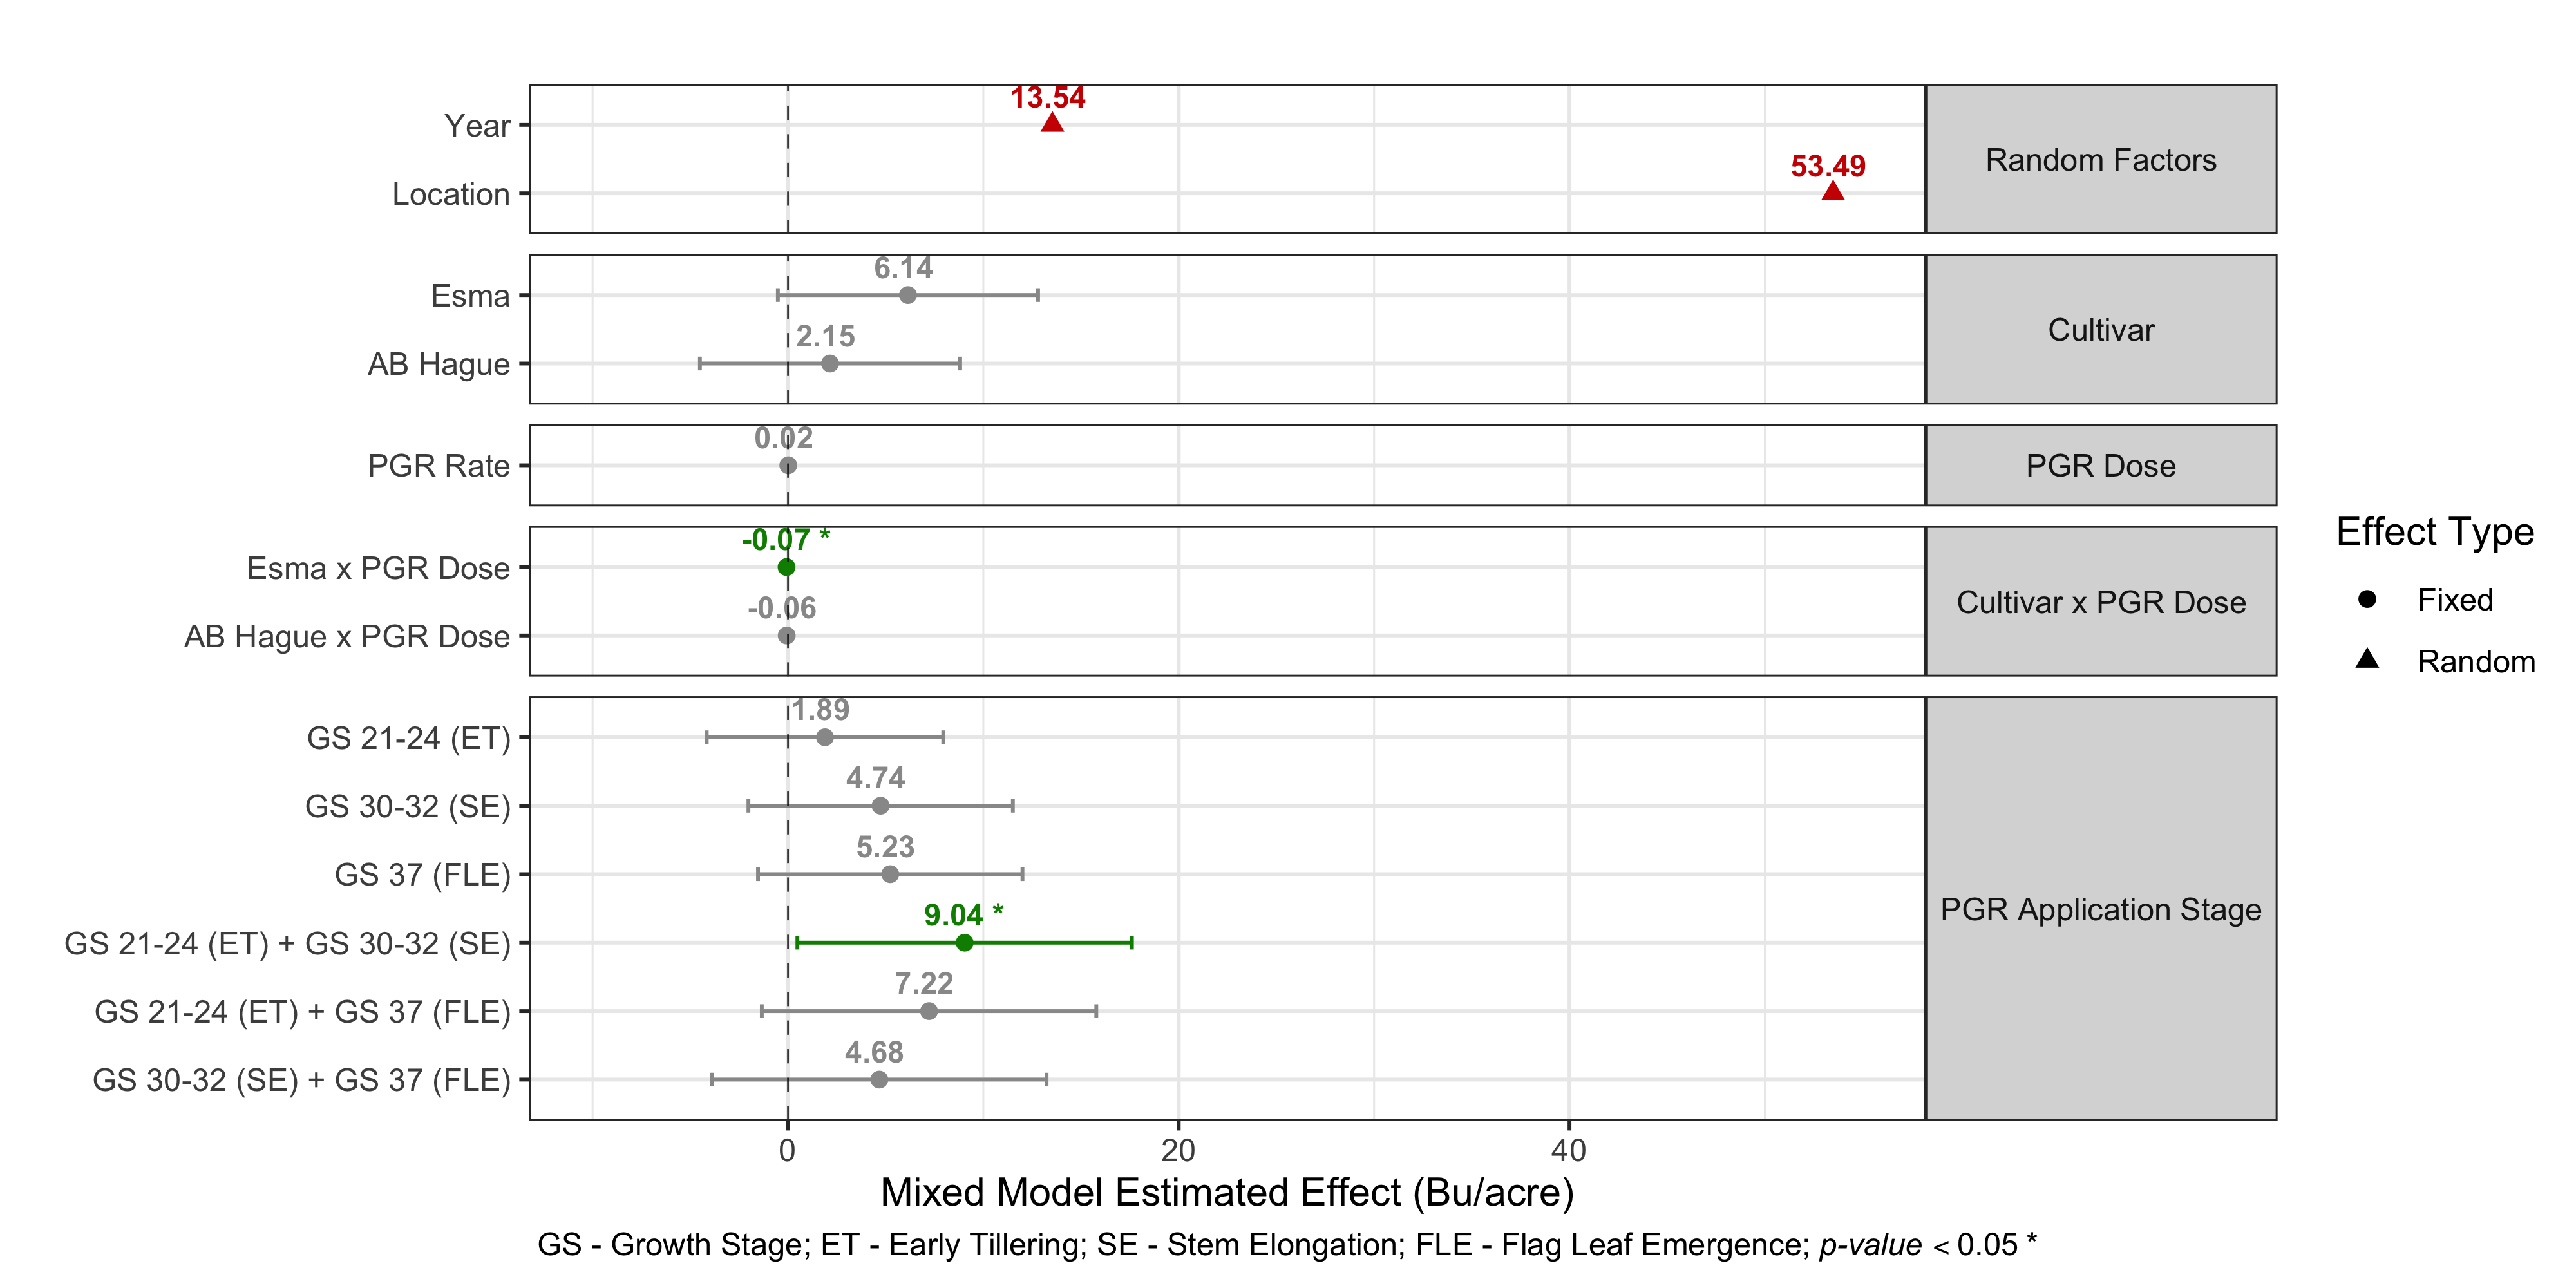

In [63]:
# Define custom order for PGR treatments

custom_order_2 <- c("Random Factors", 
                  "Year", 
                  "Cultivar",
                  "PGR Dose",
                  "Cultivar x PGR Dose",
                  "PGR Application Stage")

custom_order_3 <- c("GS 30-32 (SE) + GS 37 (FLE)",
                    "GS 21-24 (ET) + GS 37 (FLE)",
                     "GS 21-24 (ET) + GS 30-32 (SE)",
                     "GS 37 (FLE)",
                     "GS 30-32 (SE)", 
                    "GS 21-24 (ET)"
                  )

model_results <- model_results %>% 
  
  mutate(effect = recode(effect,
                         "fixed" = "Fixed"), 
         term = recode(term,
                       "year" = "Year",
                       "location" = "Location"),
    category = fct_relevel(category, custom_order_2),
         term = fct_relevel(term, custom_order_3))

options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 400)
ggplot(model_results, aes(x = estimate, y = term, shape = effect, color = significant_or_not)) +
  geom_point(size = 2) +
  geom_errorbarh(aes(xmin = ci_lower, xmax = ci_upper), height = 0.2) +  # Confidence intervals
  geom_text(aes(label = paste(round(estimate, 2), p_signif)), hjust = 0.5, vjust = -0.8, size = 3, fontface = "bold", show.legend = F) +  # Add estimate & p-value stars
  facet_grid(category ~., scales = "free_y", space = "free_y") +  # Group by category
  geom_vline(xintercept = 0, lwd = 0.2, linetype = "dashed") +  # Vertical line at zero
  scale_shape_manual(values = c(16, 17)) +  # Different shapes for fixed and random effects
  scale_color_manual(values = c("gray60", "red3", "green4")) +  # Different colors for fixed and random
  labs(title = "",
       x = "Mixed Model Estimated Effect (Bu/acre)", y = "", caption = expression("GS - Growth Stage; ET - Early Tillering; SE - Stem Elongation; FLE - Flag Leaf Emergence; " * italic("p-value") < 0.05 ~ "*"),
       shape = "Effect Type", color = "P-Value") +
 coord_cartesian(xlim = c(-10, 55))+
  theme_bw()+
  guides(color = "none")+
  theme(strip.text.y = element_text(angle = 0),
        plot.caption.position = "plot",  # ensures caption is treated as a plot component
    plot.caption = element_text(hjust = 0.5))
ggsave("figure/Yield_mixed_modeling_bu_ac.png", width = 8, height = 5, dpi = 600)

### 5.3.2 Kg / ha

In [64]:
# Set a random seed for reproducibility
set.seed(123)

# Fit the mixed model with year & location as random effects
reg_mod_int_yield_kgha <- lmer(yield_adj_to_13_5_percent ~ cultivar * PGR_dose + PGR_growth_stage +
                (1 | year) + (1 | location), 
                data = data_int %>% mutate(pgr_trt_name = fct_relevel(pgr_trt_name, "No_PGR"),
                                       cultivar = fct_relevel(cultivar, "CDC_Austenson")))

# Extract fixed effects with p-values
fixed_effects <- broom.mixed::tidy(reg_mod_int_yield_kgha, effects = "fixed") %>%
  filter(term != "(Intercept)")

# Extract confidence intervals for fixed effects
conf_int <- confint(reg_mod_int_yield_kgha, method = "Wald") %>%  # Compute 95% CIs
  as.data.frame() %>%
  rownames_to_column("term") %>%
  filter(term %in% fixed_effects$term) %>%
  rename(ci_lower = `2.5 %`, ci_upper = `97.5 %`)

# Merge CIs with fixed effects
fixed_effects <- fixed_effects %>%
  left_join(conf_int, by = "term") %>%
  mutate(
    p_signif = case_when(
      p.value < 0.001 ~ "***",
      p.value < 0.01  ~ "**",
      p.value < 0.05  ~ "*",
      TRUE ~ ""
    )
  )

# Extract random effects (variance components) - No p-values here
random_effects <- broom.mixed::tidy(reg_mod_int_yield_kgha, effects = "ran_pars") %>%
  select(-term) %>% 
  rename(term = group) %>% 
  mutate(
    term = str_replace(term, "sd__", ""),  # Clean term names
    effect = "Random",
    p_signif = "",  # No p-values for random effects
    ci_lower = NA,  # No CIs for random effects
    ci_upper = NA
  )

# Combine fixed and random effects
model_results <- bind_rows(fixed_effects, random_effects)

# Assign grouping categories
model_results <- model_results %>%
  filter(term != "Residual") %>%
  mutate(category = case_when(
    grepl("location", term) ~ "Random Factors",
    grepl("year", term) ~ "Random Factors",
    term %in% c("cultivarAB_Hague", "cultivarEsma") ~ "Cultivar",
    term == "PGR_dose" ~ "PGR Dose",
    term %in% c("cultivarAB_Hague:PGR_dose", "cultivarEsma:PGR_dose", "cultivarCDC_Austenson:PGR_dose") ~ "Cultivar x PGR Dose",
    grepl("PGR_growth_stage", term) ~ "PGR Application Stage",
    TRUE ~ "Other"
  )) %>% 
  mutate(category = fct_relevel(category, "Random Factors"),  # Convert to factor for correct order
         significant_or_not = case_when(p.value < 0.05 ~ "Significant",
                                        p.value >= 0.05 ~ "Not Significant",
                                        .default = "other"
           
         )) %>% 
  mutate(term = case_when(
    term == "cultivarAB_Hague" ~ "AB Hague",
     term == "cultivarEsma" ~ "Esma",
    term == "PGR_dose" ~ "PGR Rate",
    term == "cultivarAB_Hague:PGR_dose" ~ "AB Hague x PGR Dose",
    term == "cultivarEsma:PGR_dose" ~ "Esma x PGR Dose",
    term == "cultivarCDC_Austenson:PGR_dose" ~ "CDC Austenson x PGR Dose",
    term == "PGR_growth_stageGS 21-24 (ET)" ~ "GS 21-24 (ET)",
    term == "PGR_growth_stageGS 21-24 (ET) + GS 37 (FLE)" ~ "GS 21-24 (ET) + GS 37 (FLE)",
    term == "PGR_growth_stageGS 21-24 (ET) + GS 30-32 (SE)" ~ "GS 21-24 (ET) + GS 30-32 (SE)",
    term == "PGR_growth_stageGS 37 (FLE)" ~ "GS 37 (FLE)",
    term == "PGR_growth_stageGS 30-32 (SE)" ~ "GS 30-32 (SE)",
    term == "PGR_growth_stageGS 30-32 (SE) + GS 37 (FLE)" ~ "GS 30-32 (SE) + GS 37 (FLE)",
    TRUE ~ term
  )) 



`height` was translated to `width`.
`height` was translated to `width`.


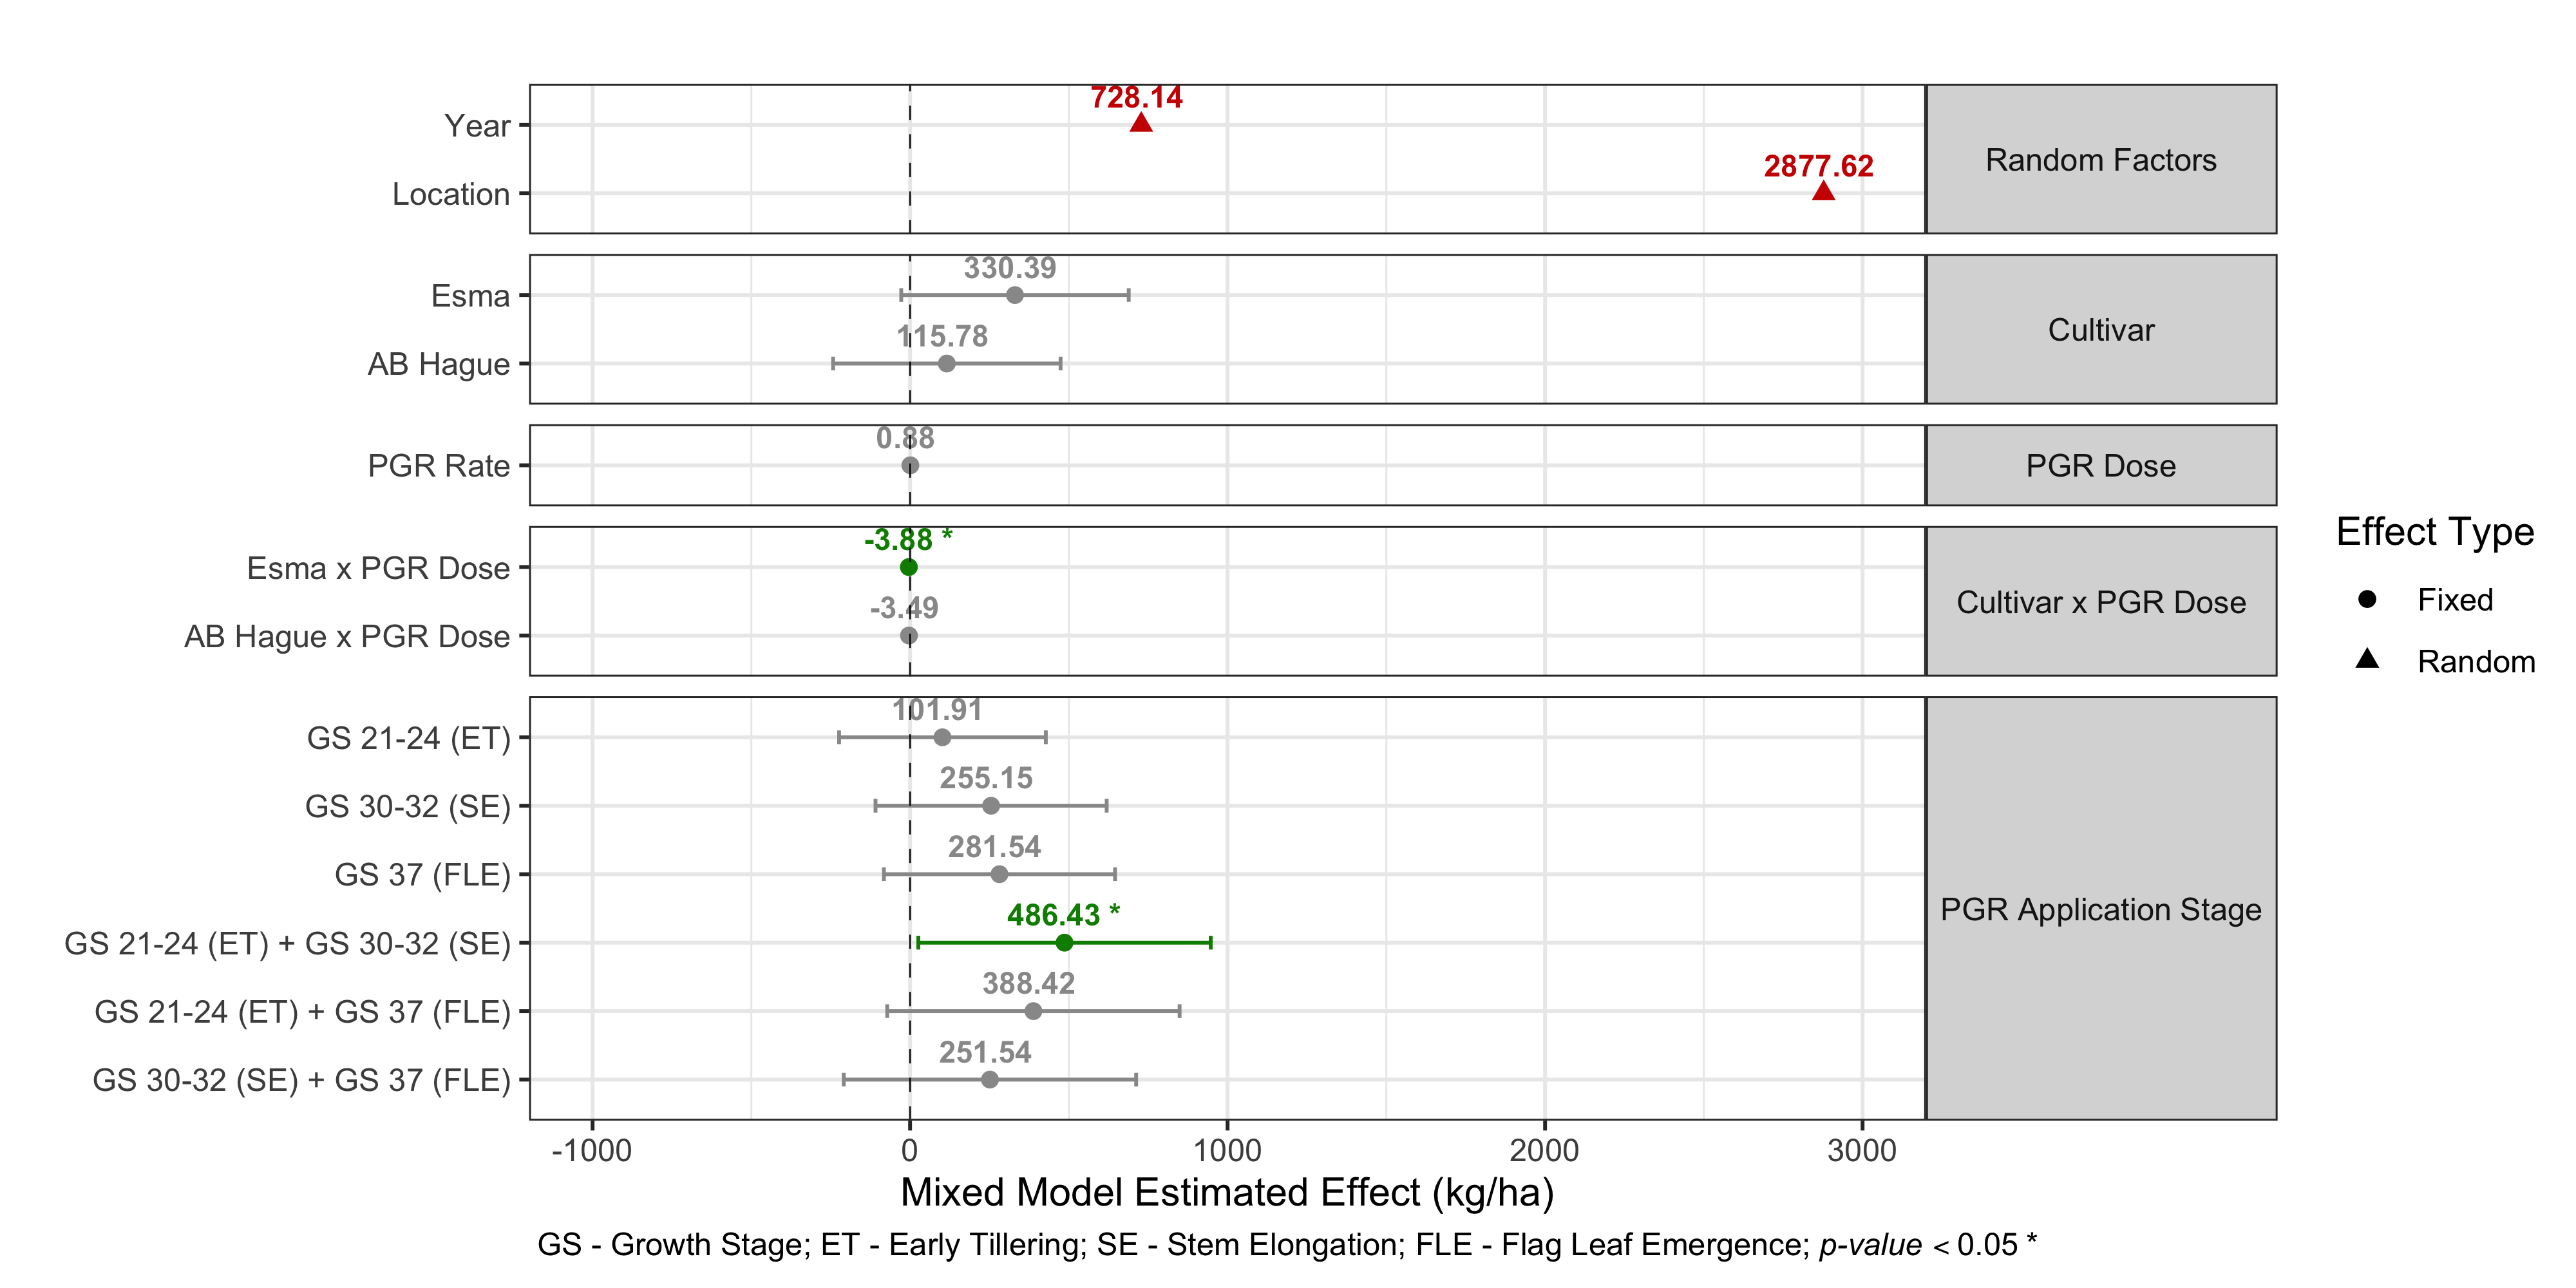

In [65]:
# Apply manual order to the "term" column for PGR treatments only
#model_results <- model_results %>%
# Plot with significance stars and confidence intervals
# Define custom order for PGR treatments
custom_order_2 <- c("Random Factors", 
                  "Year", 
                  "Cultivar",
                  "PGR Dose",
                  "Cultivar x PGR Dose",
                  "PGR Application Stage")

custom_order_3 <- c("GS 30-32 (SE) + GS 37 (FLE)",
                    "GS 21-24 (ET) + GS 37 (FLE)",
                     "GS 21-24 (ET) + GS 30-32 (SE)",
                     "GS 37 (FLE)",
                     "GS 30-32 (SE)", 
                    "GS 21-24 (ET)"
                  )

model_results <- model_results %>% 
  
  mutate(effect = recode(effect,
                         "fixed" = "Fixed"), 
         term = recode(term,
                       "year" = "Year",
                       "location" = "Location"),
    category = fct_relevel(category, custom_order_2),
         term = fct_relevel(term, custom_order_3))
ggplot(model_results, aes(x = estimate, y = term, shape = effect, color = significant_or_not)) +
  geom_point(size = 2) +
  geom_errorbarh(aes(xmin = ci_lower, xmax = ci_upper), height = 0.2) +  # Confidence intervals
  geom_text(aes(label = paste(round(estimate, 2), p_signif)), hjust = 0.5, vjust = -0.8, size = 3, fontface = "bold", show.legend = F) +  # Add estimate & p-value stars
  facet_grid(category ~., scales = "free_y", space = "free_y") +  # Group by category
  geom_vline(xintercept = 0, lwd = 0.2, linetype = "dashed") +  # Vertical line at zero
  scale_shape_manual(values = c(16, 17)) +  # Different shapes for fixed and random effects
  scale_color_manual(values = c("gray60", "red3", "green4")) +  # Different colors for fixed and random
  labs(title = "",
       x = "Mixed Model Estimated Effect (kg/ha)", y = "", caption = expression("GS - Growth Stage; ET - Early Tillering; SE - Stem Elongation; FLE - Flag Leaf Emergence; " * italic("p-value") < 0.05 ~ "*"),
       shape = "Effect Type", color = "P-Value") +
  coord_cartesian(xlim = c(-1000, 3000))+
  theme_bw()+
  guides(color = "none")+
  theme(strip.text.y = element_text(angle = 0),
        plot.caption.position = "plot",  # ensures caption is treated as a plot component
    plot.caption = element_text(hjust = 0.5))
ggsave("figure/Yield_interac_mixed_modeling_kg_ha.png", width = 8, height = 5, dpi = 600)

# Economic analysis

In [90]:
data_int_economic1 <- data_int
# Set a random seed for reproducibility
set.seed(123)

# Fit the mixed model with year & location as random effects
reg_mod_int_yield_economic <- lmer(net_return ~ cultivar * PGR_dose + PGR_growth_stage +
                (1 | year) + (1 | location), 
                data = data_int_economic1 %>% mutate(pgr_trt_name = fct_relevel(pgr_trt_name, "No_PGR"),
                                       cultivar = fct_relevel(cultivar, "CDC_Austenson")))

# Extract fixed effects with p-values
fixed_effects <- broom.mixed::tidy(reg_mod_int_yield_economic, effects = "fixed") %>%
  filter(term != "(Intercept)")

# Extract confidence intervals for fixed effects
conf_int <- confint(reg_mod_int_yield_economic, method = "Wald", level = 0.95) %>%  # Compute 95% CIs
  as.data.frame() %>%
  rownames_to_column("term") %>%
  filter(term %in% fixed_effects$term) %>%
  rename(ci_lower = `2.5 %`, ci_upper = `97.5 %`)

# Merge CIs with fixed effects
fixed_effects <- fixed_effects %>%
  left_join(conf_int, by = "term") %>%
  mutate(
    p_signif = case_when(
      p.value < 0.001 ~ "***",
      p.value < 0.01  ~ "**",
      p.value < 0.05  ~ "*",
      TRUE ~ ""
    )
  )

# Extract random effects (variance components) - No p-values here
random_effects <- broom.mixed::tidy(reg_mod_int_yield_economic, effects = "ran_pars") %>%
  select(-term) %>% 
  rename(term = group) %>% 
  mutate(
    term = str_replace(term, "sd__", ""),  # Clean term names
    effect = "Random",
    p_signif = "",  # No p-values for random effects
    ci_lower = NA,  # No CIs for random effects
    ci_upper = NA
  )

# Combine fixed and random effects
model_results <- bind_rows(fixed_effects, random_effects)

# Assign grouping categories
model_results <- model_results %>%
  filter(term != "Residual") %>%
  mutate(category = case_when(
    grepl("location", term) ~ "Random Factors",
    grepl("year", term) ~ "Random Factors",
    term %in% c("cultivarAB_Hague", "cultivarEsma") ~ "Cultivar",
    term == "PGR_dose" ~ "PGR Dose",
    term %in% c("cultivarAB_Hague:PGR_dose", "cultivarEsma:PGR_dose", "cultivarCDC_Austenson:PGR_dose") ~ "Cultivar x PGR Dose",
    grepl("PGR_growth_stage", term) ~ "PGR Application Stage",
    TRUE ~ "Other"
  )) %>% 
  mutate(category = fct_relevel(category, "Random Factors"),  # Convert to factor for correct order
         significant_or_not = case_when(p.value < 0.05 ~ "Significant",
                                        p.value >= 0.05 ~ "Not Significant",
                                        .default = "other"
           
         )) %>% 
  mutate(term = case_when(
    term == "cultivarAB_Hague" ~ "AB Hague",
     term == "cultivarEsma" ~ "Esma",
    term == "PGR_dose" ~ "PGR Rate",
    term == "cultivarAB_Hague:PGR_dose" ~ "AB Hague x PGR Dose",
    term == "cultivarEsma:PGR_dose" ~ "Esma x PGR Dose",
    term == "cultivarCDC_Austenson:PGR_dose" ~ "CDC Austenson x PGR Dose",
    term == "PGR_growth_stageGS 21-24 (ET)" ~ "GS 21-24 (ET)",
    term == "PGR_growth_stageGS 21-24 (ET) + GS 37 (FLE)" ~ "GS 21-24 (ET) + GS 37 (FLE)",
    term == "PGR_growth_stageGS 21-24 (ET) + GS 30-32 (SE)" ~ "GS 21-24 (ET) + GS 30-32 (SE)",
    term == "PGR_growth_stageGS 37 (FLE)" ~ "GS 37 (FLE)",
    term == "PGR_growth_stageGS 30-32 (SE)" ~ "GS 30-32 (SE)",
    term == "PGR_growth_stageGS 30-32 (SE) + GS 37 (FLE)" ~ "GS 30-32 (SE) + GS 37 (FLE)",
    TRUE ~ term
  )) 


`height` was translated to `width`.
`height` was translated to `width`.


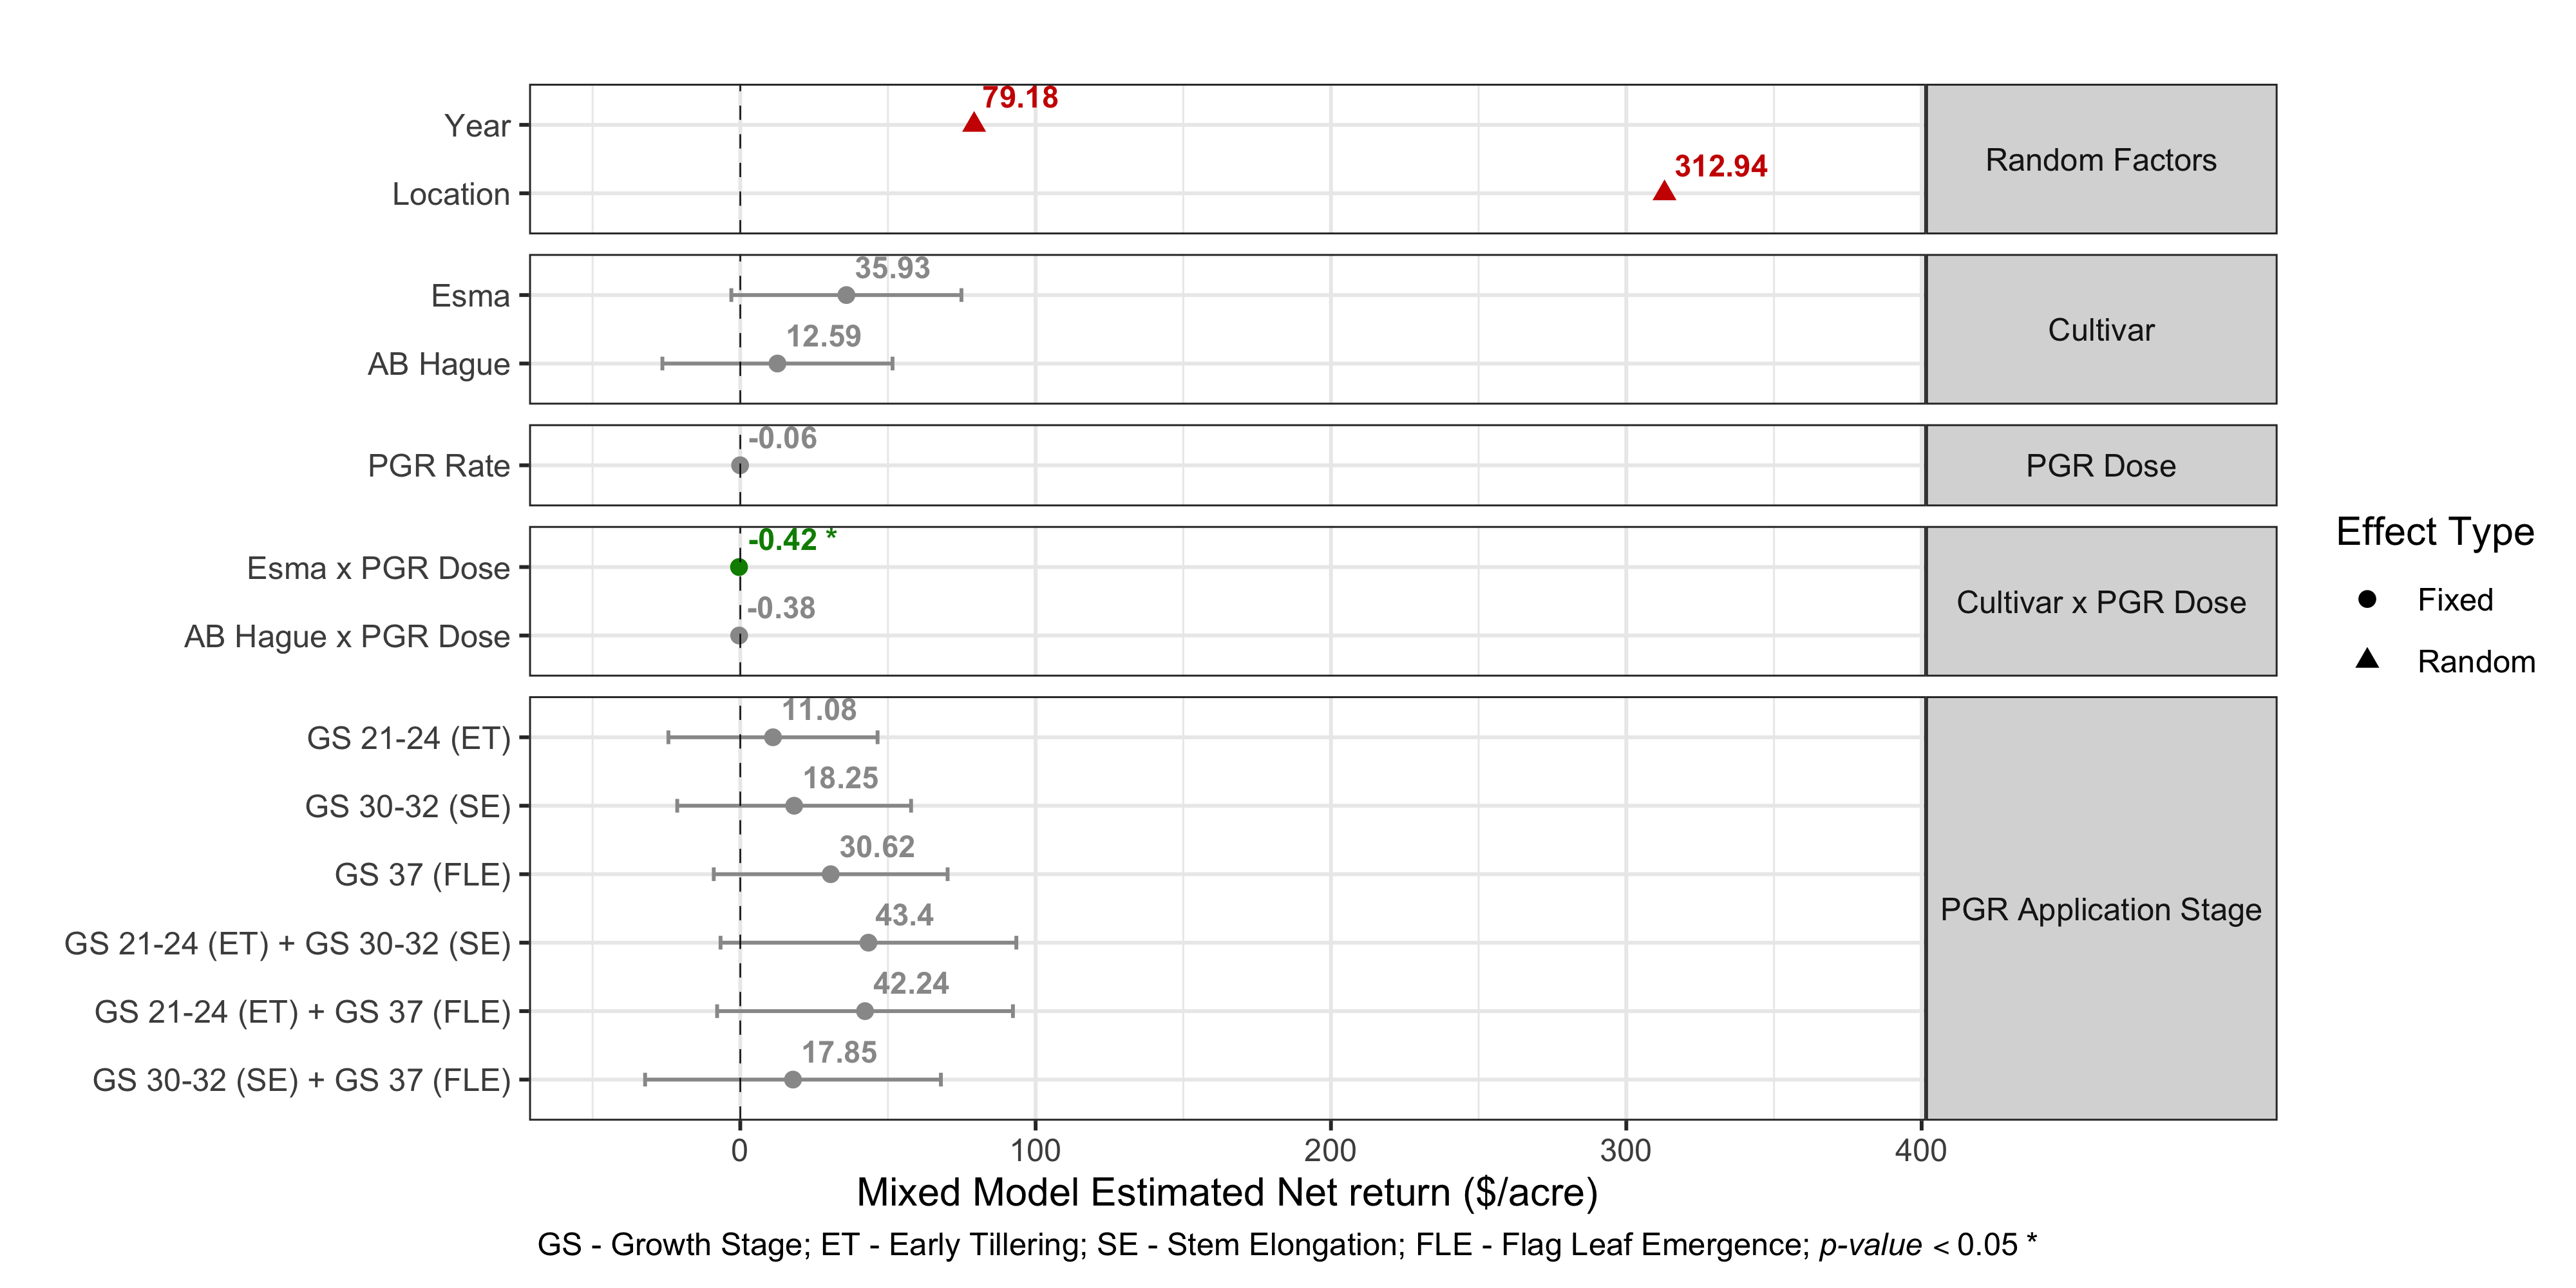

In [91]:
# Apply manual order to the "term" column for PGR treatments only
#model_results <- model_results %>%
# Plot with significance stars and confidence intervals
# Define custom order for PGR treatments
custom_order_2 <- c("Random Factors", 
                  "Year", 
                  "Cultivar",
                  "PGR Dose",
                  "Cultivar x PGR Dose",
                  "PGR Application Stage")

custom_order_3 <- c("GS 30-32 (SE) + GS 37 (FLE)",
                    "GS 21-24 (ET) + GS 37 (FLE)",
                     "GS 21-24 (ET) + GS 30-32 (SE)",
                     "GS 37 (FLE)",
                     "GS 30-32 (SE)", 
                    "GS 21-24 (ET)"
                  )

model_results <- model_results %>% 
  
  mutate(effect = recode(effect,
                         "fixed" = "Fixed"), 
         term = recode(term,
                       "year" = "Year",
                       "location" = "Location"),
    category = fct_relevel(category, custom_order_2),
         term = fct_relevel(term, custom_order_3))
ggplot(model_results, aes(x = estimate, y = term, shape = effect, color = significant_or_not)) +
  geom_point(size = 2) +
  geom_errorbarh(aes(xmin = ci_lower, xmax = ci_upper), height = 0.2) +  # Confidence intervals
  geom_text(aes(label = paste(round(estimate, 2), p_signif)), hjust = -0.1, vjust = -0.8, size = 3, fontface = "bold", show.legend = F) +  # Add estimate & p-value stars
  facet_grid(category ~., scales = "free_y", space = "free_y") +  # Group by category
  geom_vline(xintercept = 0, lwd = 0.2, linetype = "dashed") +  # Vertical line at zero
  scale_shape_manual(values = c(16, 17)) +  # Different shapes for fixed and random effects
  scale_color_manual(values = c("gray60", "red3", "green4")) +  # Different colors for fixed and random
  labs(title = "",
       x = "Mixed Model Estimated Net return ($/acre)", y = "", caption = expression("GS - Growth Stage; ET - Early Tillering; SE - Stem Elongation; FLE - Flag Leaf Emergence; " * italic("p-value") < 0.05 ~ "*"),
       shape = "Effect Type", color = "P-Value") +
  coord_cartesian(xlim = c(-50, 380))+
  theme_bw()+
  guides(color = "none")+
  theme(strip.text.y = element_text(angle = 0),
        plot.caption.position = "plot",  # ensures caption is treated as a plot component
    plot.caption = element_text(hjust = 0.5))
ggsave("figure/Yield_mixed_modeling_bu_ac.png", width = 8, height = 5, dpi = 600)